# Detección Automática de Idiomas

### Carlos Pérez Manzano

La identificación automática del idioma de un texto es una de las tareas fundamentales en el procesamiento de
lenguaje natural, siendo el primer paso para muchas aplicaciones multilingües. En este proyecto, se va a implementar un sistema completo de detección automática de idiomas utilizando diferentes técnicas evaluando comparativamente sus resultados.

Se empleará el [Europarl Parallel Corpus](https://www.statmt.org/europarl/), que contiene textos parlamentarios en múltiples idiomas de la Unión Europea.

## Estructura del Proyecto

En este proyecto emplearemos un sistema completo de detección automática de idiomas siguiendo estos pasos:

1. **Carga y preparación de los datos**: carga y limpieza de los datos originales.
2. **Exploración de los datos**: visualización de las distribuciones, análisis del vocabulario.
3. **Preprocesamiento textual**: discusión del preprocesamiento textual óptimo para la tarea a realizar.
4. **Representación vectorial**: discusión de la técnica óptima para la vectorización de los textos.
4. **Entrenamiento de clasificadores**: implementación de varios algoritmos de Machine Learning y Deep Learning y evaluación comparativa.
5. **Conclusiones y pipeline final**: comentarios sobre el modelo escogido y pipeline completo.

### Apartado 1: Carga y Preparación de los datos

Los datos de [Europarl Parallel Corpus](https://www.statmt.org/europarl/) son un conjunto de textos multilingües extraídos de las transcripciones del Parlamento Europeo. Están disponibles en múltiples idiomas, alineados por oración para facilitar tareas de traducción automática. Los archivos están comprimidos (normalmente en .gz) y contienen pares de frases correspondientes entre idiomas. Cada idioma tiene su propio archivo, y hay versiones alineadas por pares lingüísticos. Los datos están organizados de forma sencilla, con una oración por línea.

El peso de los archivos es muy grande, por lo que vamos a generar una submuestra de los textos de cada idioma, considerando un tamaño más que suficiente para obtener resultados realmente satisfactorios en los modelos que se realizarán.

El objetivo en este apartado es preparar un dataset de dos columnas, en el que se incluyen el texto y el idioma correspondiente en cada registro. Vamos a guardar el dataset resultante en un archivo `.csv` para que la carga de los datos sea más cómoda en un futuro. Para ello, preparamos una función en la que por defecto extrae 7000 textos por idioma, considerando las que tengan una longitud de entre 3 y 20 palabras. No es necesario que el texto sea extenso para que el modelo sea capaz de detectar el idioma.

Cargamos las librerías que necesitamos a lo largo del notebook y establecemos el entorno de trabajo.

In [1]:
pip install tensorflow.keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import requests
import tarfile
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
import math
import psutil
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle

plt.style.use('ggplot')
sns.set(style='whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Mounted at /content/drive


Definimos la función que nos va a permitir realizar el proceso ETL para guardar el dataset resultante en un archivo `.csv`.

In [3]:
def extrae_textos_idiomas(data_dir, langs, n_max=7000, min_palabras=3, max_palabras=20):
    """
    Extrae del EuroParl Parallel Corpus los textos en los idiomas especificados y los guarda en un DataFrame
    en el que se añade la etiqueta del idioma al que pertenece cada texto. El DataFrame se guarda en un archivo .csv.

    Args:
        data_dir: ruta en la que se guarda el archivo .csv
        langs: lista de idiomas a extraer
        n_max: número máximo de muestras a extraer por idioma (opcional)
        min_palabras: número mínimo de palabras que debe tener el texto para ser incluido (por defecto 3)
        max_palabras: número máximo de palabras que puede tener el texto para ser incluido (por defecto 20)

    Returns:
        df: DataFrame con los textos extraídos y filtrados
    """

    EXTRACT_BASE_DIR = os.path.join(data_dir, "europarl")
    os.makedirs(data_dir, exist_ok=True)

    base_url = "https://www.statmt.org/europarl/v7"
    texts, labels = [], []

    for lang in langs:
        print(f"\nProcesando idioma: {lang}")
        tgz_filename = f"{lang}-en.tgz"
        tgz_path = os.path.join(data_dir, tgz_filename)
        url = f"{base_url}/{tgz_filename}"
        extract_dir = os.path.join(EXTRACT_BASE_DIR, lang)

        try:
            if os.path.isfile(tgz_path):
                print(f"Eliminando {tgz_filename} existente...")
                os.remove(tgz_path)

            print(f"Descargando {tgz_filename}...")
            response = requests.get(url, stream=True, timeout=30)
            response.raise_for_status()
            with open(tgz_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            print(f"Descargado {tgz_filename}")
        except requests.exceptions.RequestException as e:
            print(f"Error al descargar {tgz_filename}: {e}")
            continue

        try:
            os.makedirs(extract_dir, exist_ok=True)
            with tarfile.open(tgz_path, "r:gz") as tar:
                tar.extractall(path=extract_dir)
        except Exception as e:
            print(f"Error al extraer {tgz_filename}: {e}")
            continue

        lang_file = os.path.join(extract_dir, f"europarl-v7.{lang}-en.{lang}")
        count = 0

        try:
            with open(lang_file, encoding="utf-8") as f:
                for line in f:
                    if n_max and count >= n_max:
                        break
                    text = line.strip()
                    if text:
                        n_words = len(text.split())
                        if min_palabras <= n_words <= max_palabras:
                            texts.append(text)
                            labels.append(lang)
                            count += 1
                            if count % 1000 == 0:
                                print(f"{count} muestras procesadas para {lang}")
        except Exception as e:
            print(f"Error al leer {lang_file}: {e}")
            continue

        print(f"Guardadas {count} muestras para {lang}")

        # Limpieza
        try:
            if os.path.exists(tgz_path):
                os.remove(tgz_path)
            if os.path.exists(extract_dir):
                shutil.rmtree(extract_dir)
        except Exception as e:
            print(f"Error al eliminar archivos temporales para {lang}: {e}")

    # Crear DataFrame final
    df = pd.DataFrame({"texto": texts, "idioma": labels})
    print(f"\nDataset creado con {len(df)} filas.")

    try:
        csv_path = os.path.join(data_dir, f"europarl_multilang_dataset_{n_max}.csv")
        df.to_csv(csv_path, index=False)
        print(f"Dataset guardado en {csv_path}")
    except Exception as e:
        print(f"Error al guardar el dataset: {e}")
    return df

Se van a considerar los idiomas español, francés, alemán, italiano, portugués, neerlandés y sueco. Para cada uno de estos idiomas se seleccionarán en principio 7000 textos.

In [4]:
# Ejecutar solo si no se dispone del .csv o se quiere modificar los parametros
DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/PLNCD/LanguageDetection/datasets"
#langs = ["es", "fr", "de", "it", "pt", "nl", "sv"]
#extrae_textos_idiomas(DATA_DIR, langs)

In [5]:
csv_path = os.path.join(DATA_DIR, "europarl_multilang_dataset_7000.csv")
semilla = 42
df = pd.read_csv(csv_path).sample(frac=1, random_state=semilla).reset_index(drop=True)
display(df.head())

texto idioma
0        Det är en fråga att överväga och diskutera.     sv
1  Il coordinamento e la cooperazione sono quindi...     it
2  Seja como for, aguardo ansiosamente o Livro Br...     pt
3               Anch' io ne sono in parte coinvolto.     it
4  Efectivamente, querido colega, he procedido a ...     es

Vamos a crear un diccionario de equivalencia código-idioma que será útil en lo que sigue.

In [6]:
idiomas = {
    "es": "Español",
    "fr": "Francés",
    "de": "Alemán",
    "it": "Italiano",
    "pt": "Portugués",
    "nl": "Neerlandés",
    "sv": "Sueco"
}

Veamos la distibución de los idiomas.


Distribución de idiomas:
idioma
sv    7000
it    7000
pt    7000
es    7000
nl    7000
fr    7000
de    7000
Name: count, dtype: int64


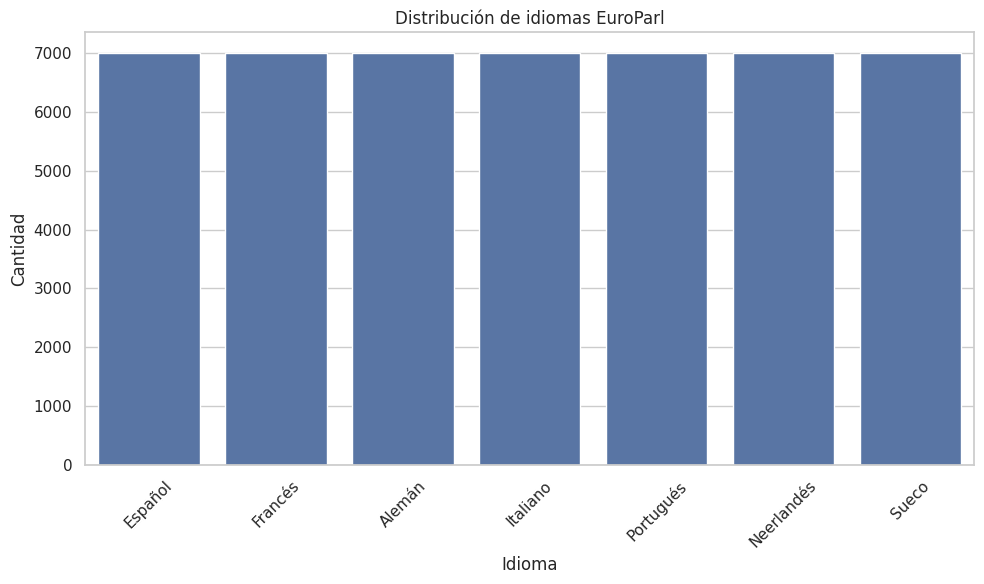

In [7]:
distribucion = df['idioma'].value_counts()
print("\nDistribución de idiomas:")
print(distribucion)

#  Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=[idiomas[cod] for cod in idiomas], y=distribucion.values)
plt.title('Distribución de idiomas EuroParl')
plt.xlabel('Idioma')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Por la construcción del dataframe, tenemos un balanceo total en los datos.

### Apartado 2: Exploración de los Datos

Ahora, vamos a explorar las características de los textos. Esto incluye la visualización de la distribución de los textos y un análisis del vocabulario.

Vamos a dividir el dataset en conjuntos de entrenamiento (70%), validación (15%) y test (15%) y en lo que sigue, haremos el análisis exploratorio para el conjunto de entrenamiento.

In [8]:
def divide_dataset(df, porcentaje_training=70, porcentaje_validacion=15, semilla=42):
    """
    Divide un dataframe en conjuntos de entrenamiento, validación y prueba.

    Args:
        df: Dataframe de pandas con el dataset.
        porcentaje_training: Porcentaje del conjunto de entrenamiento (por defecto 70%)
        porcentaje_validacion: Porcentaje del conjunto de validación (por defecto 15%)
        semilla: Semilla para la reproducibilidad de la división aleatoria

    Returns:
        Tupla con (dataframe_entrenamiento, dataframe_validacion, dataframe_test)
    """
    try:
        # Eliminar filas con valores nulos
        df_procesado = df.dropna()

        # Fijar semilla
        random.seed(semilla)
        np.random.seed(semilla)

        # Barajar el dataframe
        df_procesado = df_procesado.sample(frac=1, random_state=semilla).reset_index(drop=True)

        total = len(df_procesado)
        n_train = int(total * porcentaje_training / 100)
        n_val = int(total * porcentaje_validacion / 100)
        n_test = total - n_train - n_val

        # Dividir los conjuntos
        df_entrenamiento = df_procesado.iloc[:n_train].reset_index(drop=True)
        df_validacion = df_procesado.iloc[n_train:n_train + n_val].reset_index(drop=True)
        df_test = df_procesado.iloc[n_train + n_val:].reset_index(drop=True)

        print(f"Entrenamiento: {len(df_entrenamiento)} muestras ({porcentaje_training}%)")
        print(f"Validación: {len(df_validacion)} muestras ({porcentaje_validacion}%)")
        print(f"Test: {len(df_test)} muestras ({100 - porcentaje_training - porcentaje_validacion}%)")

        return df_entrenamiento, df_validacion, df_test

    except Exception as e:
        print(f"Error al dividir el dataset: {str(e)}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

df_train,df_val,df_test = divide_dataset(df)

Entrenamiento: 34300 muestras (70%)
Validación: 7350 muestras (15%)
Test: 7350 muestras (15%)


Analicemos la distribución de los idiomas en los distintos conjuntos de datos.

Distribución de categorías (porcentaje):


Entrenamiento (%)  Validación (%)  Prueba (%)
idioma                                                   
Alemán              14.448980       13.959184   13.850340
Español             14.297376       14.340136   14.176871
Francés             14.268222       14.367347   14.285714
Italiano            14.154519       14.367347   14.816327
Neerlandés          14.268222       14.680272   13.972789
Portugués           14.177843       14.299320   14.775510
Sueco               14.384840       13.986395   14.122449

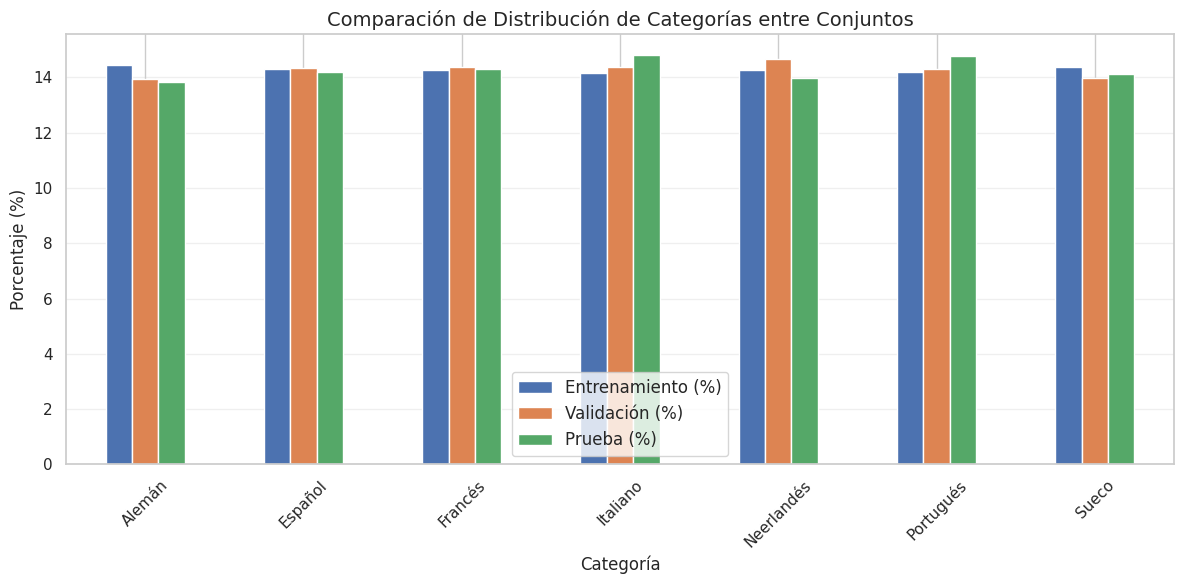

In [9]:
# Calculamos la proporción de cada categoría
proporciones_train = df_train['idioma'].map(idiomas).value_counts(normalize=True) * 100
proporciones_val = df_val['idioma'].map(idiomas).value_counts(normalize=True) * 100
proporciones_test = df_test['idioma'].map(idiomas).value_counts(normalize=True) * 100

# Creamos un dataframe para comparar las proporciones
df_balance = pd.DataFrame({
    'Entrenamiento (%)': proporciones_train,
    'Validación (%)': proporciones_val,
    'Prueba (%)': proporciones_test
})

print("Distribución de categorías (porcentaje):")
display(df_balance)

# Visualizamos la comparación
df_balance.plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Distribución de Categorías entre Conjuntos', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Se sigue manteniendo el balanceo entre clases tras la división, luego no es algo que debamos tener en cuenta para los clasificadores.

Visualicemos ahora como se distribuye la longitud de los textos de manera global y según el idioma.

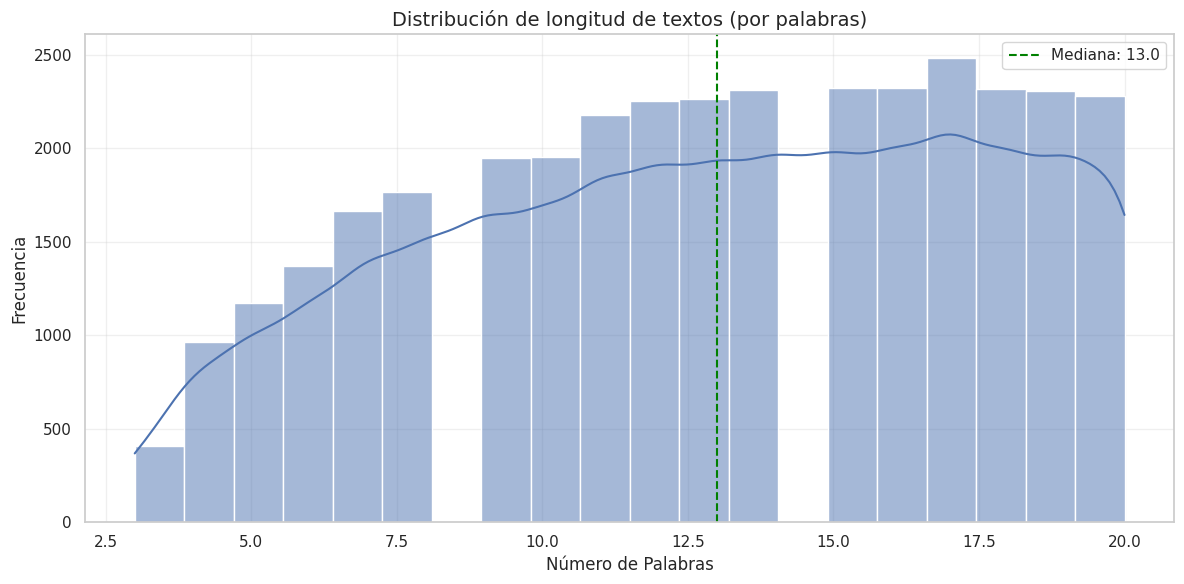

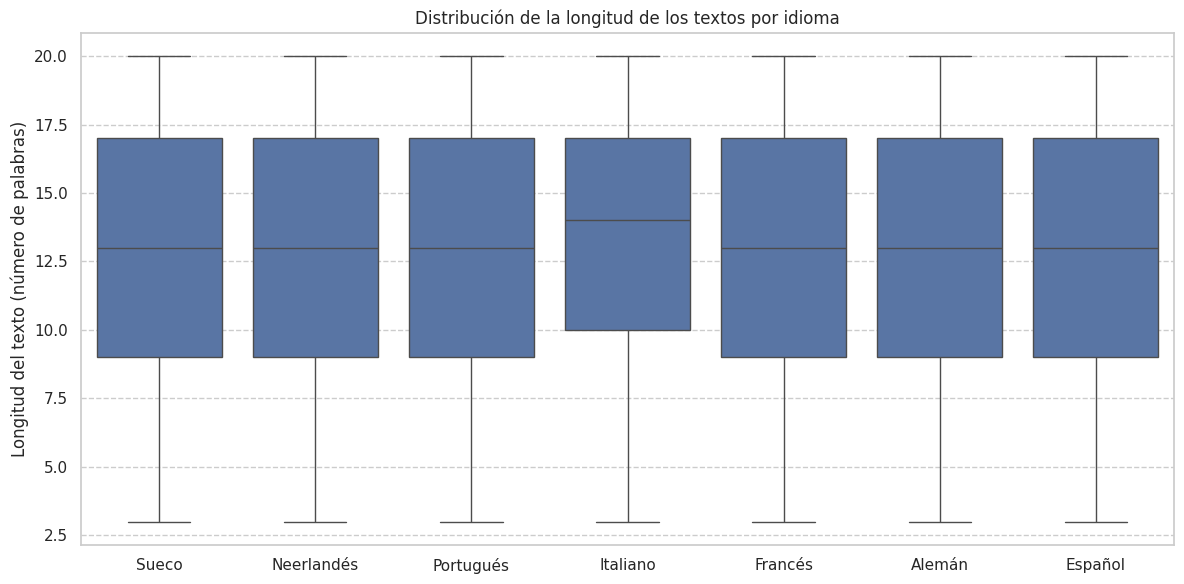

In [10]:
df_train['longitud_texto'] = df_train['texto'].apply(lambda x: len(str(x).split()))

# Distribución de longitud en palabras
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='longitud_texto', bins=20, kde=True)
plt.axvline(df_train['longitud_texto'].median(), color='green', linestyle='--',
            label=f'Mediana: {df_train["longitud_texto"].median():.1f}')
plt.title('Distribución de longitud de textos (por palabras)', fontsize=14)
plt.xlabel('Número de Palabras', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot por idioma
df_train['idioma_nombre'] = df_train['idioma'].map(idiomas)
plt.figure(figsize=(12, 6))
sns.boxplot(x='idioma_nombre', y='longitud_texto', data=df_train)
plt.title('Distribución de la longitud de los textos por idioma')
plt.xlabel('')
plt.ylabel('Longitud del texto (número de palabras)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

df_train.drop(['longitud_texto', 'idioma_nombre'], axis=1, inplace=True)

Hagamos ahora un análisis de la diversidad y riqueza del vocabulario por idioma. Esto es útil para ver si un idioma es repetitvo o si por el contrario tiene gran variedad de términos. Formalmente, podemos definir para cada idioma $l$ la riqueza $R_l$ como:

 $$R_l = \frac{|\text{Vocabulario}_l|}{\text{TotalPalabras}_l}$$
donde:
- $|\text{Vocabulario}_l|$ es el conjunto de palabras únicas (tokens), presentes en todos los textos del idioma $l$.
- $\text{TotalPalabras}_l$ es el número total de palabras (tokens) en los textos del idioma $l$.

De esta manera, la riqueza léxica de un idioma $l$ es mayor conforme más cercano a 1 sea $R_l$.

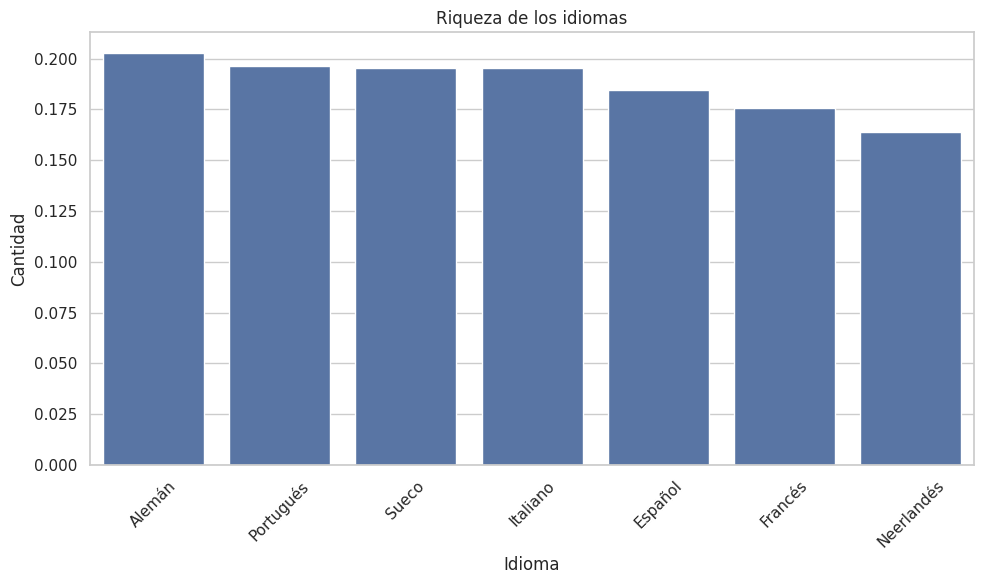

idioma
de    0.202805
pt    0.196463
sv    0.195459
it    0.195429
es    0.184668
fr    0.175835
nl    0.164051
Name: texto, dtype: float64


In [11]:
riqueza = df_train.groupby("idioma")["texto"].apply(lambda x: len(set(" ".join(x).split())) / len(" ".join(x).split())).sort_values(ascending=False)

#  Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=[idiomas[cod] for cod in riqueza.index], y=riqueza.values)
plt.title('Riqueza de los idiomas')
plt.xlabel('Idioma')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(riqueza)

El alemán es el idioma de los considerados con mayor riqueza léxica, mientras que el neerlandés es el que menor variedad posee.

Visualizamos ahora las palabras más frecuentes por idioma.

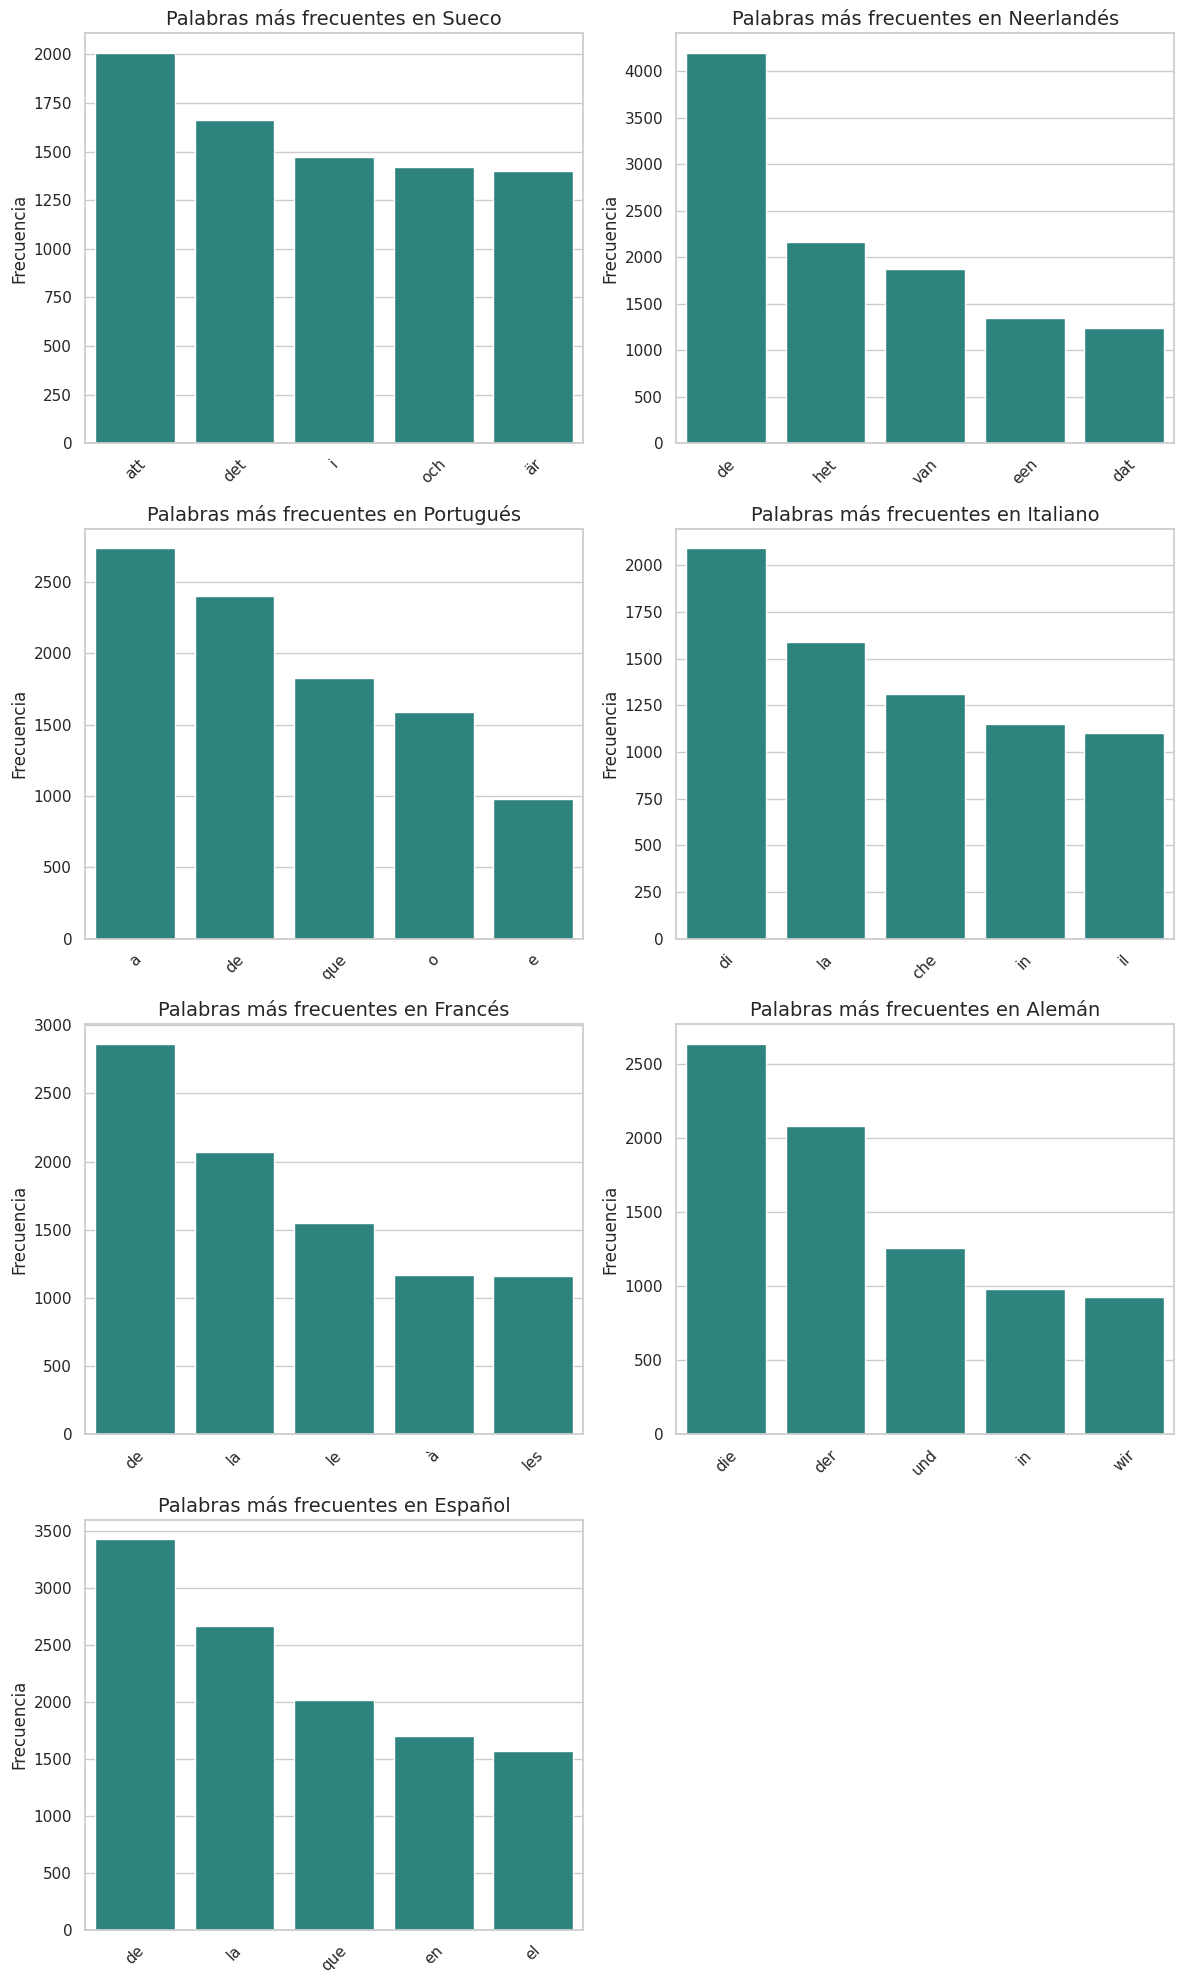

In [12]:
def top_n_words_per_language(df, n=5):
    word_freq_by_lang = {}
    for lang in df['idioma'].unique():
        df_lang = df[df['idioma'] == lang]
        all_text_lang = ' '.join(df_lang['texto']).lower()
        words = all_text_lang.split()
        word_counts = Counter(words)
        top_n = word_counts.most_common(n)
        word_freq_by_lang[lang] = top_n
    return word_freq_by_lang

top_words = top_n_words_per_language(df_train, n=5)

num_languages = len(top_words)
cols = 2
rows = math.ceil(num_languages / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()

for idx, (lang, freq_list) in enumerate(top_words.items()):
    ax = axes[idx]
    words = [item[0] for item in freq_list]
    frequencies = [item[1] for item in freq_list]
    data = pd.DataFrame({
        'Palabra': words,
        'Frecuencia': frequencies,
        'Grupo': lang
    })

    sns.barplot(
        data=data,
        x='Palabra',
        y='Frecuencia',
        hue='Grupo',
        palette='viridis',
        ax=ax,
        legend=False
    )

    ax.set_title(f'Palabras más frecuentes en {idiomas[lang]}', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# Ocultamos los ejes que han quedado vacios
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


A primera vista, las palabras más comunes en cada idioma son, como era de esperar, artículos y preposiciones. Un aspecto interesante es que, por ejemplo, la palabra "de" aparece con alta frecuencia en la mayoría de los idiomas, lo cual sugiere que no será un indicador fiable ni exclusivo para identificar un idioma específico.

Las palabras que tendrán un gran peso a priori para la identificación del idioma serán aquellas que no aparezcan, o en una menor medida en el resto de los idiomas.

Este enfoque es precisamente el que sigue la técnica TF-IDF (Term Frequency–Inverse Document Frequency), que pondera las palabras no solo por su frecuencia en un texto, sino también considerando su rareza en el conjunto general. De este modo, las palabras comunes como artículos o preposiciones, presentes en casi todos los idiomas, recibirán un peso bajo, mientras que aquellas más específicas o características de un idioma en particular obtendrán un peso mayor, contribuyendo así de manera más significativa a la tarea de clasificación.

Formalmente, para un término $t$ en un documento $d$, la ponderación TF-IDF se calcula como:

$$\text{TF-IDF}(t,d) = \text{TF}(t,d) \times \text{IDF}(t)$$

Donde:
- $\text{TF}(t,d)$ es la frecuencia del término en el documento
- $\text{IDF}(t) = \log(\frac{N}{df_t})$, siendo $N$ el número total de documentos y $df_t$ el número de documentos que contienen el término $t$

Identifiquemos qué terminos son más distintivos de cada idioma, utilizando la métrica TF-IDF.

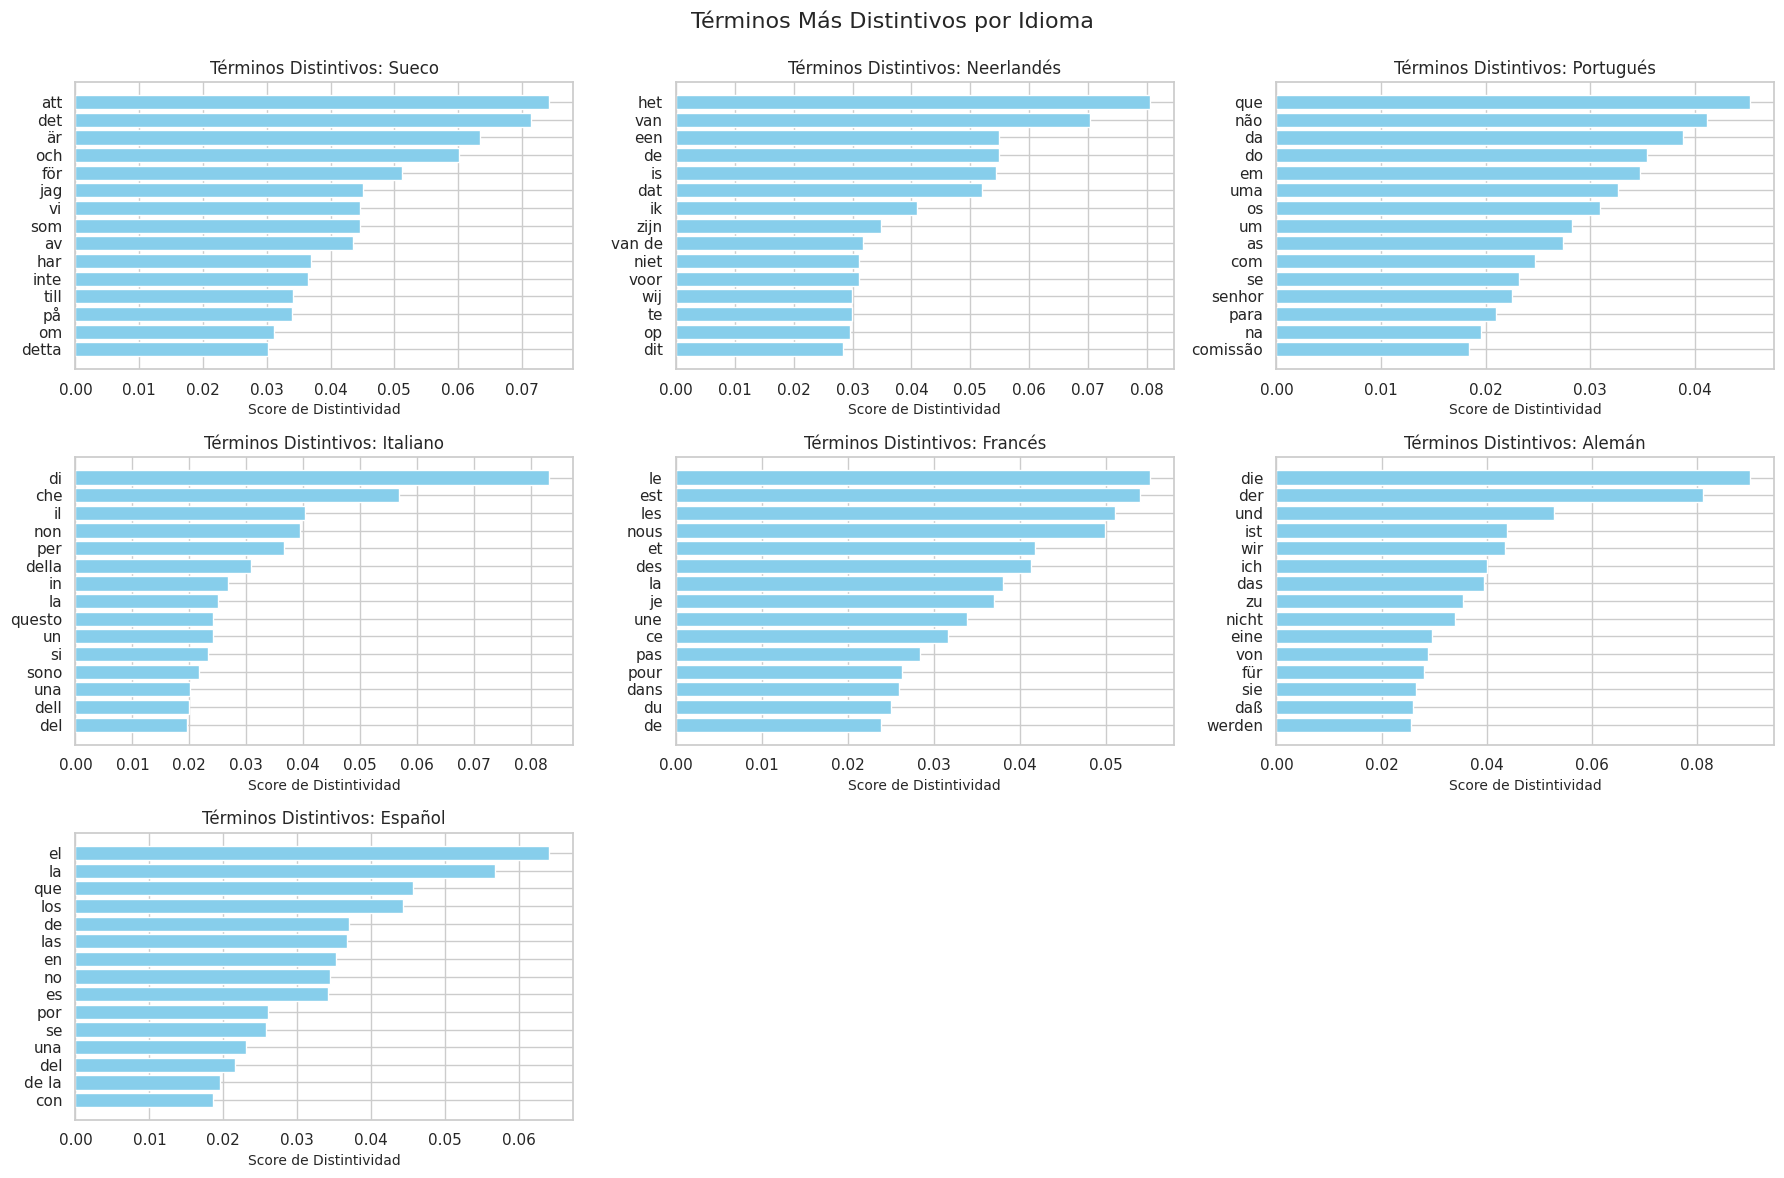


Términos más distintivos por idioma:

Sueco:
  - att: 0.0743
  - det: 0.0714
  - är: 0.0635
  - och: 0.0602
  - för: 0.0512
  - jag: 0.0451
  - vi: 0.0447
  - som: 0.0446
  - av: 0.0436
  - har: 0.0369
  - inte: 0.0365
  - till: 0.0341
  - på: 0.0340
  - om: 0.0312
  - detta: 0.0301

Neerlandés:
  - het: 0.0805
  - van: 0.0704
  - een: 0.0549
  - de: 0.0548
  - is: 0.0544
  - dat: 0.0519
  - ik: 0.0409
  - zijn: 0.0349
  - van de: 0.0318
  - niet: 0.0311
  - voor: 0.0311
  - wij: 0.0299
  - te: 0.0298
  - op: 0.0295
  - dit: 0.0284

Portugués:
  - que: 0.0453
  - não: 0.0411
  - da: 0.0389
  - do: 0.0355
  - em: 0.0347
  - uma: 0.0327
  - os: 0.0309
  - um: 0.0283
  - as: 0.0274
  - com: 0.0247
  - se: 0.0232
  - senhor: 0.0225
  - para: 0.0210
  - na: 0.0196
  - comissão: 0.0184

Italiano:
  - di: 0.0832
  - che: 0.0568
  - il: 0.0403
  - non: 0.0395
  - per: 0.0366
  - della: 0.0308
  - in: 0.0267
  - la: 0.0250
  - questo: 0.0242
  - un: 0.0242
  - si: 0.0232
  - sono: 0.0218
  - u

In [13]:
def identificar_terminos_distintivos(df):
    """
    Identifica términos más distintivos para cada idioma usando TF-IDF.

    Args:
        df: DataFrame con textos e idiomas

    Returns:
        Diccionario con términos distintivos por idioma
    """

    # Creamos un vectorizador TF-IDF
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        ngram_range=(1, 2)
    )

    # Para cada idioma, calculamos los términos más distintivos
    terminos_distintivos = {}

    for idioma in df['idioma'].unique():
        # Preparamos corpus "uno contra todos"
        textos_idioma = df[df['idioma'] == idioma]['texto'].tolist()
        textos_otros = df[df['idioma'] != idioma]['texto'].tolist()

        # Etiquetamos los textos (1 para la idioma actual, 0 para las demás)
        todos_textos = textos_idioma + textos_otros
        etiquetas = [1] * len(textos_idioma) + [0] * len(textos_otros)

        # Vectorizamos
        X = tfidf_vectorizer.fit_transform(todos_textos)
        feature_names = tfidf_vectorizer.get_feature_names_out()

        # Calculamos score para cada término como diferencia entre promedios
        X_array = X.toarray()
        scores = []

        for j in range(X_array.shape[1]):  # Para cada término
            # Promedio para el idioma actual vs. otros idiomas
            avg_lang = np.mean(X_array[:len(textos_idioma), j])
            avg_others = np.mean(X_array[len(textos_idioma):, j])

            # La diferencia es nuestro score de distintividad
            score = avg_lang - avg_others
            scores.append((feature_names[j], score))

        # Ordenamos por score y tomamos los 15 mejores
        scores.sort(key=lambda x: x[1], reverse=True)
        terminos_distintivos[idioma] = scores[:15]

    # Visualizamos términos distintivos por idioma
    n_intents = len(terminos_distintivos)
    n_cols = min(3, n_intents)
    n_rows = (n_intents + n_cols - 1) // n_cols

    plt.figure(figsize=(18, n_rows * 4))

    for i, (idioma, terms) in enumerate(terminos_distintivos.items()):
        plt.subplot(n_rows, n_cols, i+1)

        terms_only = [term for term, _ in terms]
        scores_only = [score for _, score in terms]

        # Ordenamos para mejor visualización
        sorted_indices = np.argsort(scores_only)
        sorted_terms = [terms_only[i] for i in sorted_indices]
        sorted_scores = [scores_only[i] for i in sorted_indices]

        # Gráfico de barras horizontales
        plt.barh(range(len(sorted_terms)), sorted_scores, color='skyblue')
        plt.yticks(range(len(sorted_terms)), sorted_terms)
        plt.title(f'Términos Distintivos: {idiomas[idioma]}', fontsize=12)
        plt.xlabel('Score de Distintividad', fontsize=10)
        plt.tight_layout()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle('Términos Más Distintivos por Idioma', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Mostramos resultados textualmente
    print("\nTérminos más distintivos por idioma:")
    for idioma, terms in terminos_distintivos.items():
        print(f"\n{idiomas[idioma]}:")
        for term, score in terms:
            print(f"  - {term}: {score:.4f}")

    return terminos_distintivos

terminos_distintivos = identificar_terminos_distintivos(df_train)

La palabra "de" ha perdido relevancia en la mayoría de los idiomas. Como mencionamos anteriormente, al ser una palabra extremadamente común en muchos idiomas, la métrica TF-IDF lo refleja asignándole un peso bajo.

En cambio, en el caso del español por ejemplo, una palabra como "el" resulta más distintiva: aunque también es frecuente, aparece principalmente en textos en español y mucho menos en otros idiomas, lo que le otorga un mayor valor dentro de esta métrica.

Ademas, la tecnica TF-IDF nos permite realizar una reduccion de la dimensionalidad para visualizar los textos en 2D.

Aplicando SVD (Truncated Singular Value Decomposition) en Conjunto Entrenamiento...
Reducción completada en 0.99 segundos en Conjunto Entrenamiento
Varianza explicada por las primeras 2 componentes: 0.0158


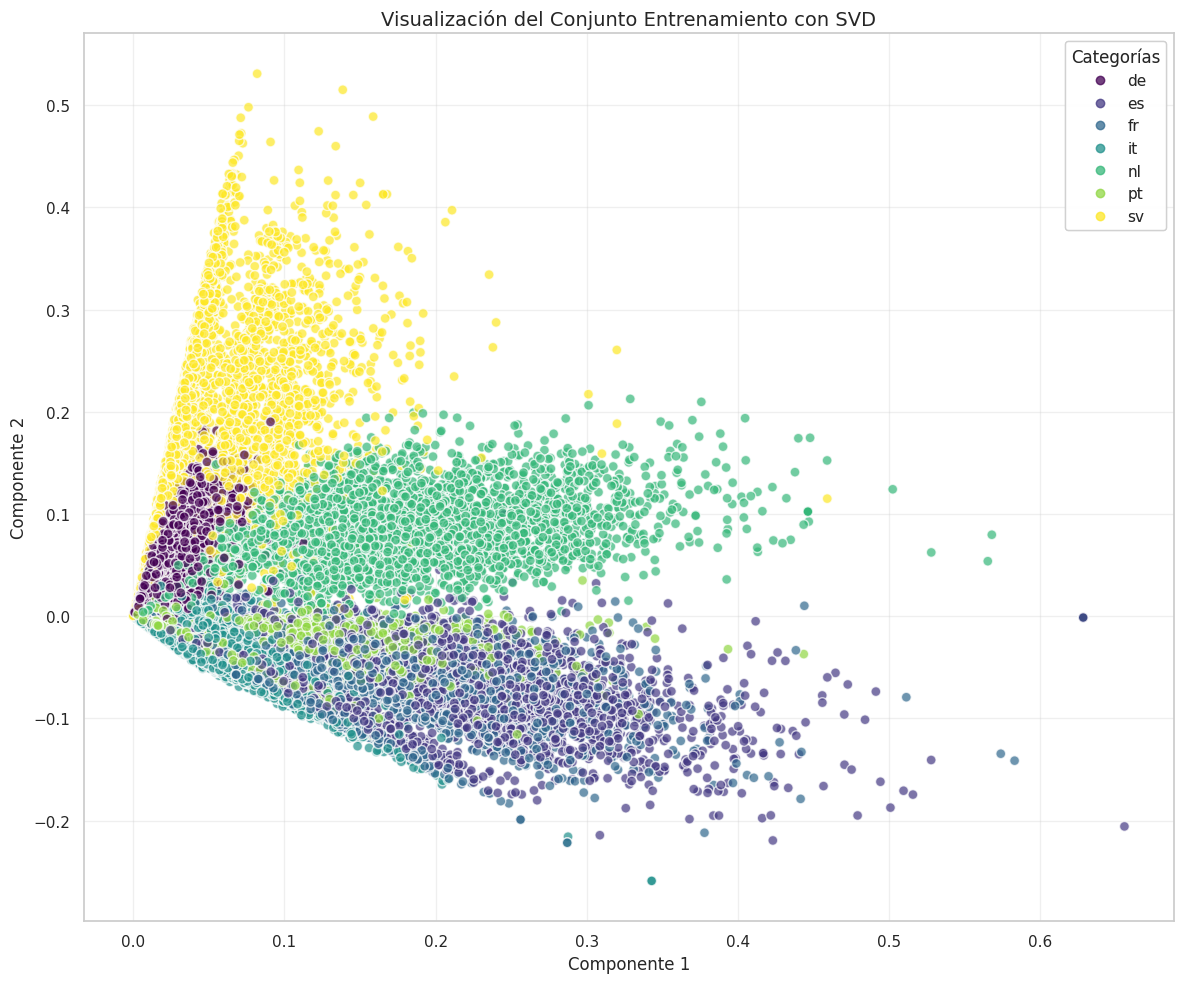

Aplicando SVD (Truncated Singular Value Decomposition) en Conjunto Validación...
Reducción completada en 0.24 segundos en Conjunto Validación
Varianza explicada por las primeras 2 componentes: 0.0158


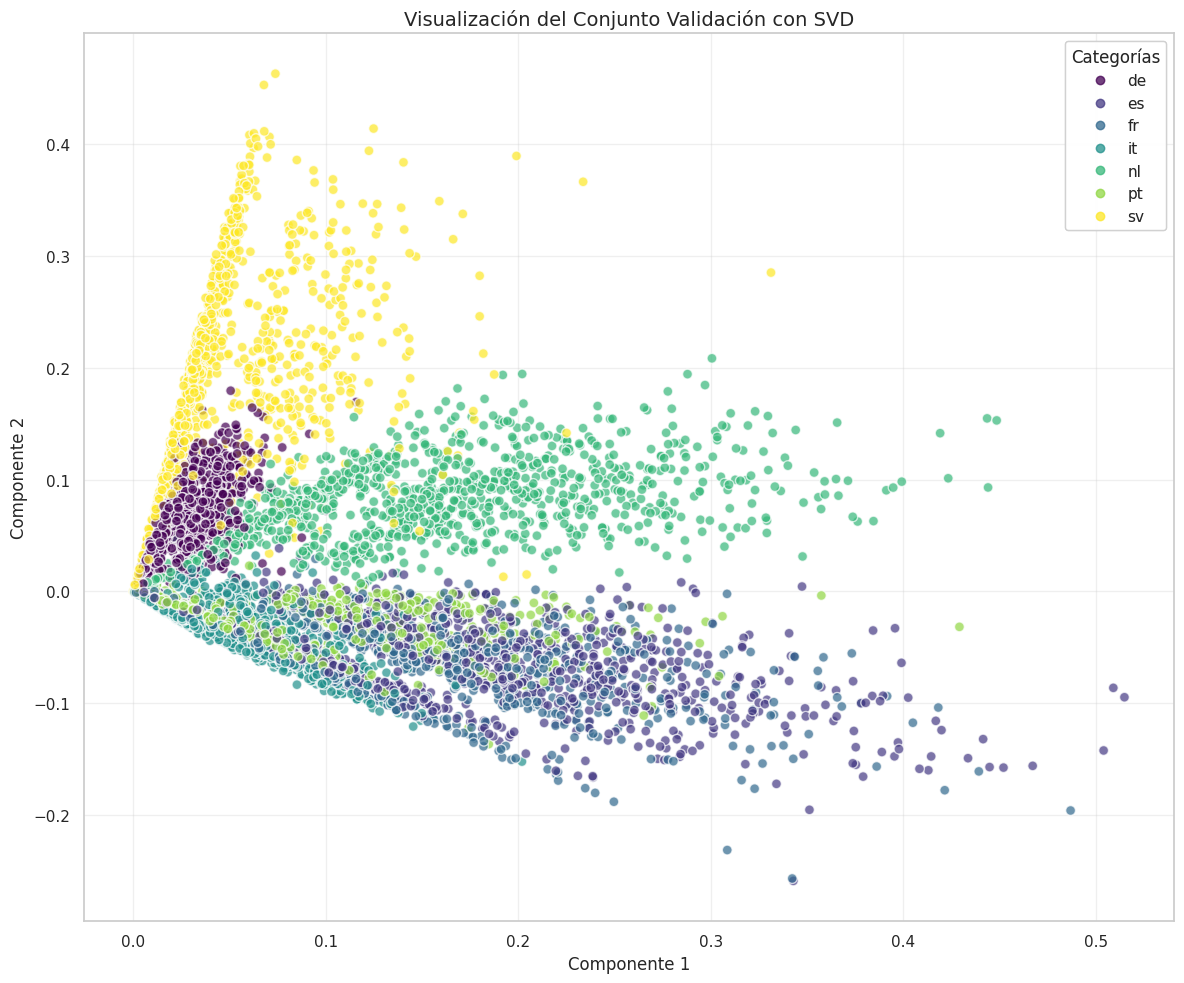

Aplicando SVD (Truncated Singular Value Decomposition) en Conjunto Prueba...
Reducción completada en 0.30 segundos en Conjunto Prueba
Varianza explicada por las primeras 2 componentes: 0.0158


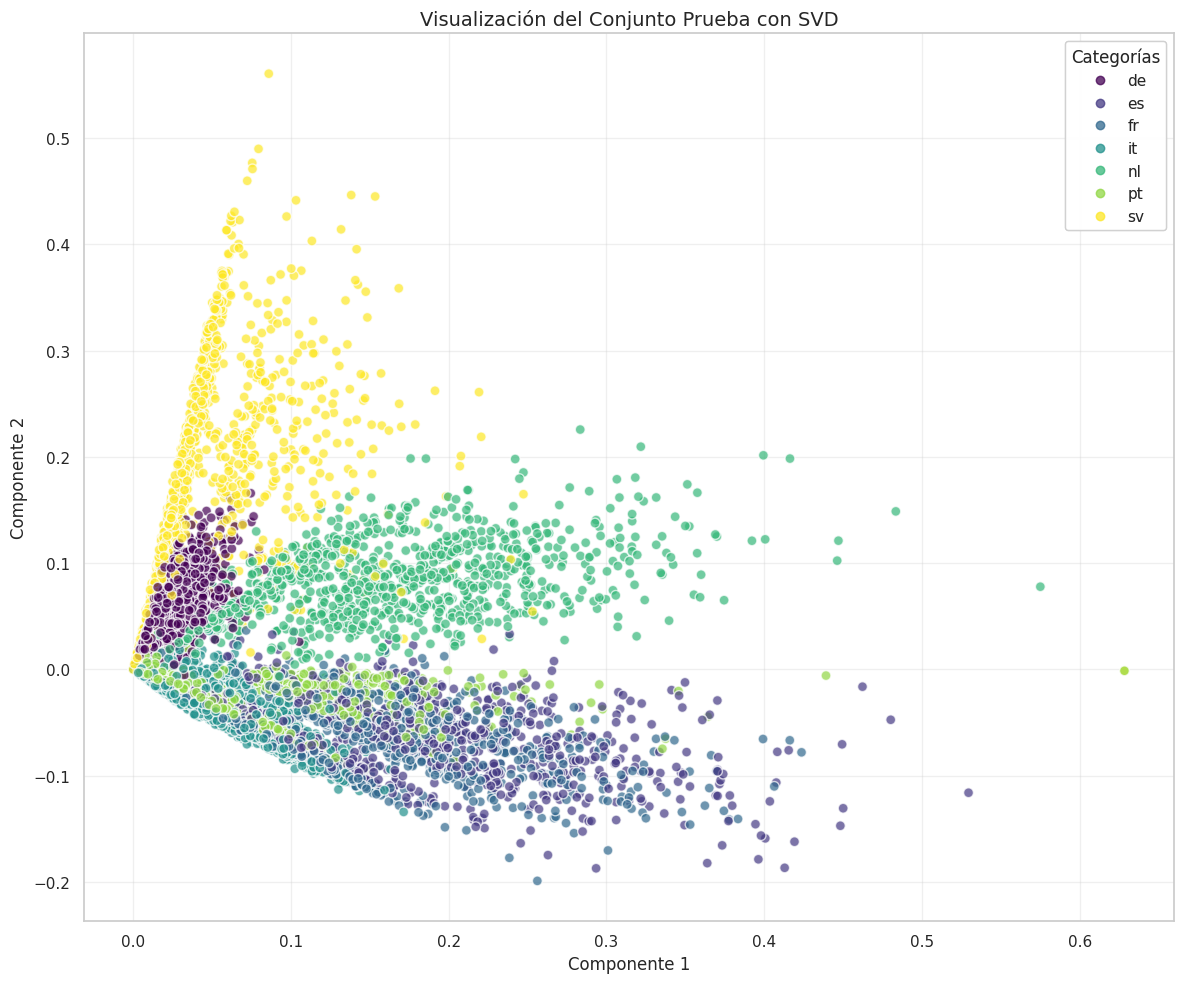

In [14]:
def visualizar_textos2D(df_train, df_test, columna_texto='texto', random_state = 42):
    """
    Visualiza los textos en 2D aplicando TF-IDF + SVD (reducción de dimensionalidad).

    Args:
        df_train: DataFrame de entrenamiento.
        df_test: DataFrame de prueba.
        columna_texto: Nombre de la columna que contiene los textos.
        random_state: Semilla para la reproducibilidad de la división aleatoria

    """
    # Inicializamos el vectorizador
    vectorizador = TfidfVectorizer(
        min_df=2,
        max_df=0.95,
        max_features=5000,
        use_idf=True,
        smooth_idf=True,
    )

    # Aplicamos reducción de dimensionalidad
    modelo_reduccion = TruncatedSVD(n_components=2, random_state=random_state)
    for dataframe, conjunto in zip([df_train, df_val,df_test], ['Conjunto Entrenamiento', 'Conjunto Validación','Conjunto Prueba']):

      # Convertimos las etiquetas a valores numéricos para la visualización
      clases_unicas = np.unique(dataframe['idioma'])
      mapping = {clase: i for i, clase in enumerate(clases_unicas)}
      y_num = np.array([mapping[clase] for clase in dataframe['idioma']])

      inicio = time.time()
      print(f"Aplicando SVD (Truncated Singular Value Decomposition) en {conjunto}...")

      if conjunto == 'Conjunto Entrenamiento':
        X_train_tfidf = vectorizador.fit_transform(dataframe[columna_texto])
        X_reducido = modelo_reduccion.fit_transform(X_train_tfidf)
      else:
        X_valtest = vectorizador.transform(dataframe[columna_texto])
        X_reducido = modelo_reduccion.transform(X_valtest)

      tiempo = time.time() - inicio
      print(f"Reducción completada en {tiempo:.2f} segundos en {conjunto}")

      # Mostramos la varianza explicada
      varianza_explicada = modelo_reduccion.explained_variance_ratio_
      varianza_acumulada = np.cumsum(varianza_explicada)
      print(f"Varianza explicada por las primeras 2 componentes: {np.sum(varianza_explicada):.4f}")

      # Visualizamos los resultados
      plt.figure(figsize=(12, 10))
      scatter = plt.scatter(X_reducido[:, 0], X_reducido[:, 1],
                          c=y_num, cmap='viridis',
                          alpha=0.7, s=50, edgecolors='w')

      # Añadimos leyenda
      legend1 = plt.legend(scatter.legend_elements()[0], clases_unicas,
                          loc="best", title="Categorías")
      plt.gca().add_artist(legend1)

      plt.title(f'Visualización del {conjunto} con SVD', fontsize=14)
      plt.xlabel('Componente 1', fontsize=12)
      plt.ylabel('Componente 2', fontsize=12)
      plt.grid(alpha=0.3)
      plt.tight_layout()
      plt.show()

visualizar_textos2D(df_train,df_test)

La separación entre idiomas es, en general, bastante clara. Algunos, como el esloveno, se distinguen con nitidez y aparecen bien diferenciados del resto en el espacio reducido. Sin embargo, otros idiomas como el español y el francés presentan mayor solapamiento, lo que indica que sus representaciones textuales comparten características comunes y resultan más difíciles de separar visualmente.

Esto nos ha dado una cierta idea entre la similitud entre idiomas. Estudiemos algo más a fondo este aspecto, pues es un factor a tener en cuenta para las posibles confusiones de los modelos posteriores. Los idiomas que se van a poder clasificar mejor son aquellos que se diferencian en una mayor medida del resto.

Tomaremos la similitud entre idiomas como la distancia del coseno de los vectores medios TF-IDF.

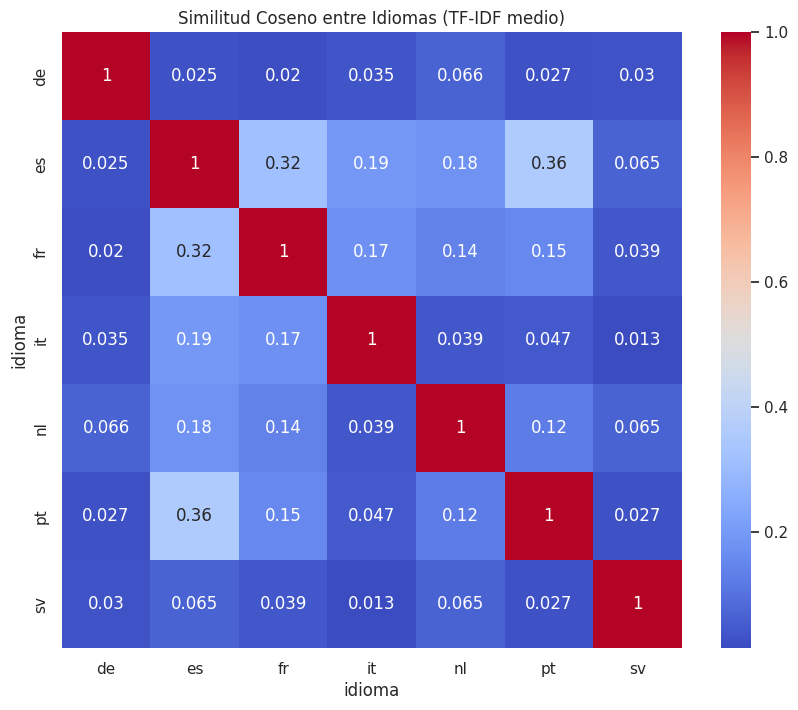

Ranking de idiomas según similitud media con el resto:
    Similitud_Media
es         0.188892
fr         0.139972
pt         0.122860
nl         0.101567
it         0.083308
sv         0.039825
de         0.033594


In [15]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        ngram_range=(1, 2)
    )
X_tfidf = tfidf_vectorizer.fit_transform(df["texto"])

# Crear un dataframe e identificamos los idiomas
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_tfidf["idioma"] = df["idioma"].values

# Calcular vector promedio por idioma
mean_vectors = df_tfidf.groupby("idioma").mean()

# Similitud coseno entre idiomas
similarity_matrix = cosine_similarity(mean_vectors)
sim_df = pd.DataFrame(similarity_matrix, index=mean_vectors.index, columns=mean_vectors.index)

# Visualizar matriz de similitud
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap="coolwarm")
plt.title("Similitud Coseno entre Idiomas (TF-IDF medio)")
plt.show()

# Calcular la similitud media con el resto de idiomas
similaridad_media = {}

for idioma in sim_df.index:
    similitudes = sim_df.loc[idioma].drop(idioma)  # Excluye la diagonal
    similaridad_media[idioma] = similitudes.mean()

# Convertir a DataFrame para visualizar el ranking
ranking_similitud = pd.DataFrame.from_dict(similaridad_media, orient='index', columns=['Similitud_Media'])
ranking_similitud = ranking_similitud.sort_values(by='Similitud_Media', ascending=False)

# Mostrar ranking
print("Ranking de idiomas según similitud media con el resto:")
print(ranking_similitud)

El español es el idioma que más similitudes tiene con el resto. Un 0.36 con el portugués, 0.32 con el francés, 0.19 con el italiano y 0.18 con el neerlandés. En consecuencia, este sea seguramente el idioma más difícil de clasificar para los modelos de clasificación.

Además, el ranking basado en la similitud media de cada idioma con el resto proporciona una información muy valiosa, ya que permite identificar tanto los idiomas más distintivos (aquellos con valores de similitud más bajos, que comparten pocas características con los demás) como los más difíciles de clasificar, que presentan mayor similitud con otros idiomas y, por tanto, tienden a solaparse en el espacio de características, como vimos en la gráfica anterior.

### Apartado 3: Preprocesamiento Textual

En el Procesamiento del Lenguaje Natural es común aplicar ciertas modificaciones a los textos de entrada, como son eliminar signos de puntuación, números, espacios extra y stopwords, la conversión a minúsculas y aplicar stemming o lematización.

La elección del preprocesamiento del texto es un factor determinante en el rendimiento de los modelos de clasificación, y debe ajustarse siempre a la naturaleza específica de la tarea. En el caso particular de la detección automática de idiomas, es fundamental preservar al máximo las características lingüísticas propias de cada lengua. Por ello, no se deben aplicar transformaciones morfológicas como la lematización o el stemming, ya que alteran la forma original de las palabras y eliminan señales importantes para la identificación del idioma. Tampoco es recomendable eliminar los signos de puntuación, ya que algunos idiomas utilizan símbolos característicos que pueden ser muy informativos. Finalmente, las stopwords no deben eliminarse, pues, aunque en otras tareas como análisis de sentimientos o clasificación de documentos se consideran ruido, en este contexto son claves, ya que suelen ser las palabras más frecuentes y distintivas de cada idioma, y por tanto, muy útiles para los modelos de clasificación.

Preparamos una función que va a ser la encargada de realizar el preprocesamiento de los textos del dataset.

In [16]:
def preprocesar_texto(texto):
    """
    Aplica preprocesamiento a un texto.

    Args:
        texto (str): Texto a procesar.

    Returns:
        str: Texto preprocesado.
    """
    text = texto.lower()  # convertimos a minusculas
    text = re.sub(r'\d+', '', text)  # eliminamos numeros
    text = re.sub(r'\s+', ' ', text).strip()  # eliminamos espacios en blanco innecesarios
    return text

def preprocesa_dataset(dataframe):
    """
    Aplica preprocesamiento a todo un dataset.

    Args:
        dataframe (DataFrame): DataFrame con textos a procesar en la columna 'texto'

    Returns:
        DataFrame: DataFrame con textos preprocesados en la columna 'texto_procesado'
    """

    df_procesado = dataframe.copy()
    df_procesado['texto_procesado'] = df_procesado['texto'].apply(preprocesar_texto)

    return df_procesado

In [17]:
df_train_processed = preprocesa_dataset(df_train)
df_val_processed = preprocesa_dataset(df_val)
df_test_processed = preprocesa_dataset(df_test)
display(df_train_processed.head())

texto idioma  \
0  Jag tror att hon efter sitt tal kommer att få ...     sv   
1  Den stora frågan är snarare under vilket budge...     sv   
2  De structurele problemen waardoor Europa een h...     nl   
3  Jag tror ärligt talat att en utvärdering av de...     sv   
4                       Vraag nr. 1 van (H-0022/00):     nl   

                                     texto_procesado  
0  jag tror att hon efter sitt tal kommer att få ...  
1  den stora frågan är snarare under vilket budge...  
2  de structurele problemen waardoor europa een h...  
3  jag tror ärligt talat att en utvärdering av de...  
4                               vraag nr. van (h-/):

Codificamos la variable objetivo.

In [18]:
codidioma_to_idx = {codidioma: idx for idx,codidioma in enumerate(df_train['idioma'].unique())}
idx_to_codidioma = {idx: codidioma for idx,codidioma in codidioma_to_idx.items()}

df_train_processed['idioma_idx'] = df_train_processed['idioma'].map(codidioma_to_idx)
df_val_processed['idioma_idx'] = df_val_processed['idioma'].map(codidioma_to_idx)
df_test_processed['idioma_idx'] = df_test_processed['idioma'].map(codidioma_to_idx)

### Apartado 4. Representación Vectorial

Los textos en bruto deben transformarse en una representación numérica para que los algoritmos de aprendizaje automático sean capaces de procesarlos. De esta manera, debemos trasladar las secuencias lingüísticas en vectores que capturen las características relevantes del contenido textual.

En el contexto de la tarea de detección automática de idiomas, la elección de la técnica de vectorización es especialmente crítica, ya que las diferencias entre lenguas pueden manifestarse a distintos niveles: desde patrones léxicos y morfológicos hasta secuencias de caracteres que son características propias de un idioma concreto. Vamos a considerar las siguientes posibilidades para la vectorización del texto:

* **TF-IDF de n-gramas de palabras**: técnica empleada en los apartados anteriores.

* **TF-IDF de n-gramas de caracteres**: Análoga a la técnica ya vista, pero capturando secuencias de caracteres. Captura patrones fonéticos y ortográficos característicos.

* **Letter frecuency vectors**: cuenta la frecuencia de cada palabra del alfabeto. Es ligero y útil para distinguir idiomas con distribuciones diferentes de caracteres. Por ejemplo, el español usa la "ñ".

* **Hashing vectorizer con n-gramas de caracteres**:  Variante de los n-gramas que usa funciones hash para asignar características a índices en lugar de usar un vocabulario explícito. Es escalable a grandes volúmenes de textos e idiomas, pues evita almacenar la totalidad del vocabulario.

Podemos ver la técnica óptima para la vectorización según los resultados obtenidos por los clasificadores. Por ello, vamos a entrenar un modelo inicial NaiveBayes para elegir la vectorización que da mejores resultados. Compararemos además los tiempos de ejecución.

Vamos a definir una serie de funciones que nos va a ser útil en lo que sigue.


In [19]:
def entrenar_clasificador(clasificador, X_train, y_train, X_val, y_val, nombre_clasificador):
    """
    Entrena un clasificador y mide métricas de rendimiento computacional.

    Args:
        clasificador: Modelo de clasificación a entrenar
        X_train: Características de entrenamiento
        y_train: Etiquetas de entrenamiento
        X_val: Características de validación
        y_test: Etiquetas de validación
        nombre_clasificador: Nombre descriptivo del clasificador

    Returns:
        tuple: (clasificador_entrenado, tiempo_entrenamiento, tiempo_prediccion, memoria_modelo, accuracy)
    """
    print(f"Entrenando {nombre_clasificador}...")

    # Registramos estado inicial de memoria
    proceso = psutil.Process()
    memoria_inicial = proceso.memory_info().rss / (1024 * 1024)  # En MB

    # Medimos el tiempo de entrenamiento
    inicio = time.time()
    clasificador.fit(X_train, y_train)
    tiempo_entrenamiento = time.time() - inicio

    # Registramos estado final de memoria y calculamos diferencia
    memoria_final = proceso.memory_info().rss / (1024 * 1024)  # En MB
    memoria_usada = memoria_final - memoria_inicial

    # Estimamos el tamaño del modelo guardado
    with open('temp_model.joblib', 'wb') as f:
        joblib.dump(clasificador, f)

    tamaño_modelo = os.path.getsize('temp_model.joblib') / (1024 * 1024)  # En MB
    os.remove('temp_model.joblib')  # Limpiamos el archivo temporal

    # Medimos el tiempo de predicción
    inicio = time.time()
    y_pred = clasificador.predict(X_val)
    tiempo_prediccion = time.time() - inicio

    # Calculamos accuracy inicial
    accuracy = np.mean(y_pred == y_val)

    # Imprimimos información de rendimiento
    print(f"  Tiempo de entrenamiento: {tiempo_entrenamiento:.2f} segundos")
    print(f"  Tiempo de predicción: {tiempo_prediccion:.2f} segundos")
    print(f"  Memoria utilizada durante entrenamiento: {memoria_usada:.2f} MB")
    print(f"  Tamaño del modelo guardado: {tamaño_modelo:.2f} MB")
    print(f"  Accuracy inicial: {accuracy:.4f}")
    print("-" * 50)

    return clasificador, tiempo_entrenamiento, tiempo_prediccion, tamaño_modelo, accuracy

def vectorizar_y_entrenar(X_train, X_val, y_train, y_val, tipo_vectorizacion, clasificador):
    """
    Aplica la vectorización especificada y entrena el modelo con las métricas deseadas.

    Returns:
        Salida de entrenar_clasificador y tiempo de vectorización
    """
    nombre = f"{tipo_vectorizacion} + {clasificador.__class__.__name__}"

    # Elegir vectorizador según técnica
    if tipo_vectorizacion == 'chars-tf-idf':
        vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

    elif tipo_vectorizacion == 'words-tf-idf':
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))

    elif tipo_vectorizacion == 'letter-freq':
        from sklearn.base import BaseEstimator, TransformerMixin

        class LetterFrequencyVectorizer(BaseEstimator, TransformerMixin):
            def __init__(self):
                self.alphabet = list("abcdefghijklmnopqrstuvwxyzáéíóúüñ")

            def fit(self, X, y=None):
                return self

            def transform(self, X):
                vectors = []
                for text in X:
                    text = text.lower()
                    total = len(text)
                    freq = [text.count(c) / total if total > 0 else 0 for c in self.alphabet]
                    vectors.append(freq)
                return np.array(vectors)

        vectorizer = LetterFrequencyVectorizer()

    elif tipo_vectorizacion == 'hashing':
        vectorizer = HashingVectorizer(analyzer='char', ngram_range=(2, 4), n_features=2**18, alternate_sign=False)

    else:
        raise ValueError(f"Técnica de vectorización '{tipo_vectorizacion}' no reconocida.")

    # Medir tiempo de vectorización + entrenamiento
    inicio = time.time()
    pipeline = make_pipeline(vectorizer, clasificador)
    resultado = entrenar_clasificador(pipeline, X_train, y_train, X_val, y_val, nombre)
    tiempo_total = time.time() - inicio
    print(f"Tiempo total de vectorización y entrenamiento: {tiempo_total:.2f} segundos")

    return resultado + (tiempo_total,)  # Añadimos tiempo_total al final


def vectorizar_datos(X_train, X_val, tipo_vectorizacion):
    """
    Aplica la vectorización especificada y devuelve los datos vectorizados y el vectorizador.

    Returns:
        tuple: (X_train_vec, X_val_vec, vectorizer, tiempo_vectorizacion)
    """

    inicio = time.time()

    if tipo_vectorizacion == 'chars-tf-idf':
        vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

    elif tipo_vectorizacion == 'words-tf-idf':
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))

    elif tipo_vectorizacion == 'letter-freq':
        from sklearn.base import BaseEstimator, TransformerMixin

        class LetterFrequencyVectorizer(BaseEstimator, TransformerMixin):
            def __init__(self):
                self.alphabet = list("abcdefghijklmnopqrstuvwxyzáéíóúüñ")

            def fit(self, X, y=None):
                return self

            def transform(self, X):
                vectors = []
                for text in X:
                    text = text.lower()
                    total = len(text)
                    freq = [text.count(c) / total if total > 0 else 0 for c in self.alphabet]
                    vectors.append(freq)
                return np.array(vectors)

        vectorizer = LetterFrequencyVectorizer()

    elif tipo_vectorizacion == 'hashing':
        vectorizer = HashingVectorizer(analyzer='char', ngram_range=(2, 4), n_features=2**18, alternate_sign=False)

    else:
        raise ValueError(f"Técnica de vectorización '{tipo_vectorizacion}' no reconocida.")

    # Vectorización
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    tiempo_vectorizacion = time.time() - inicio
    print(f"Tiempo de vectorización: {tiempo_vectorizacion:.2f} segundos")

    return X_train_vec, X_val_vec, vectorizer, tiempo_vectorizacion

Pasamos pues, a comparar las distintas técnicas de vectorización.


 Evaluando chars-tf-idf...
Tiempo de vectorización: 4.99 segundos
Entrenando chars-tf-idf...
  Tiempo de entrenamiento: 0.06 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 9.66 MB
  Accuracy inicial: 0.9988
--------------------------------------------------

 Evaluando words-tf-idf...
Tiempo de vectorización: 1.54 segundos
Entrenando words-tf-idf...
  Tiempo de entrenamiento: 0.09 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: -25.86 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9989
--------------------------------------------------

 Evaluando letter-freq...
Tiempo de vectorización: 0.86 segundos
Entrenando letter-freq...
  Tiempo de entrenamiento: 0.05 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 0.00 MB
  Accuracy inicial: 0.8680
------------------------------

Tecnica Vectorizacion  Tiempo Vectorizacion  Tiempo Entrenamiento  \
0          chars-tf-idf              4.990282              0.064075   
1          words-tf-idf              1.537018              0.089838   
2           letter-freq              0.860620              0.049584   
3               hashing              4.962527              0.126403   

   Tiempo Prediccion  Accuracy  
0           0.013980  0.998776  
1           0.013348  0.998912  
2           0.001780  0.868027  
3           0.019535  0.998095

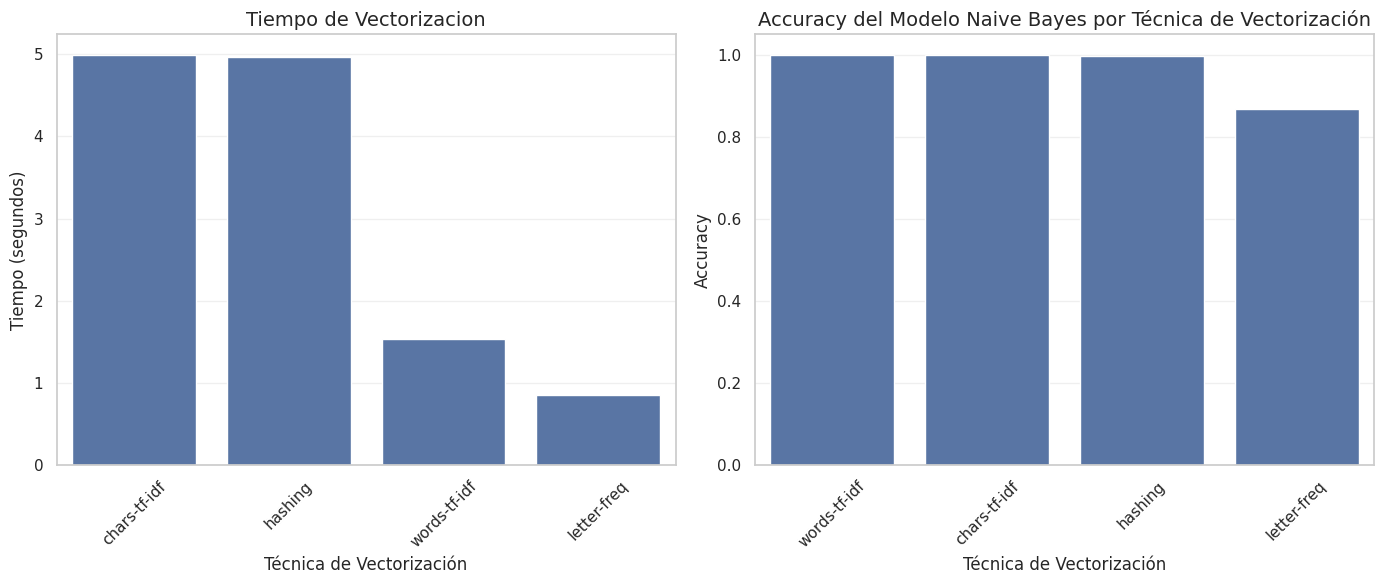

In [20]:
# Clasificador Naive Bayes
nb_classifier = MultinomialNB()

# Técnicas de vectorización a comparar
vectorization_techniques = ['chars-tf-idf', 'words-tf-idf', 'letter-freq', 'hashing']

results = []

# Datos de entrenamiento y validación
X_train = df_train_processed['texto_procesado']
y_train = df_train_processed['idioma_idx']
X_val = df_val_processed['texto_procesado']
y_val = df_val_processed['idioma_idx']

for tech in vectorization_techniques:
    print(f"\n Evaluando {tech}...")

    X_train_vec, X_val_vec, vectorizer, tiempo_vectorizacion = vectorizar_datos(X_train, X_val, tech)

    trained_classifier, tiempo_entrenamiento, tiempo_prediccion, tamaño_modelo, accuracy = entrenar_clasificador(
        nb_classifier, X_train_vec, y_train, X_val_vec, y_val, f"{tech}"
    )

    results.append({
        'Tecnica Vectorizacion': tech,
        'Tiempo Vectorizacion': tiempo_vectorizacion,
        'Tiempo Entrenamiento': tiempo_entrenamiento,
        'Tiempo Prediccion': tiempo_prediccion,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

print("\n--- Resultados Comparativos ---")
display(results_df)

# Graficar tiempos de ejecución
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Tecnica Vectorizacion', y='Tiempo Vectorizacion', data=results_df.sort_values(by='Tiempo Vectorizacion', ascending=False))
plt.title('Tiempo de Vectorizacion', fontsize=14)
plt.xlabel('Técnica de Vectorización', fontsize=12)
plt.ylabel('Tiempo (segundos)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)


# Graficar Accuracy
plt.subplot(1, 2, 2)
sns.barplot(x='Tecnica Vectorizacion', y='Accuracy', data=results_df.sort_values(by='Accuracy', ascending=False))
plt.title('Accuracy del Modelo Naive Bayes por Técnica de Vectorización', fontsize=14)
plt.xlabel('Técnica de Vectorización', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Atentiendo a los resultados, utilizaremos la vectorización en N-gramas de palabras TF-IDF. En concreto, consideramos unigramas y bigramas.

### Apartado 5. Entrenamiento de Clasificadores

#### Apartado 5.1. Modelos de Machine Learning

Una vez que ya hemos decidido la técnica de vectorización, es el momento de entrenar los clasificadores. En primer lugar, veamos los modelos de Machine Learning que pueden dar un buen rendimiento y para ello preparamos una función que se encarga de realizar la comparación.

In [21]:
X_train_vec, X_val_vec, vectorizer, tiempo_vectorizacion = vectorizar_datos(X_train, X_val, 'words-tf-idf')

Tiempo de vectorización: 1.52 segundos


In [22]:
def comparar_modelos_ml(clasificadores, X_train, X_val, y_train, y_val):
    """
    Compara distintos clasificadores usando TF-IDF por palabras.

    Args:
        clasificadores (list): Lista de tuplas (nombre, instancia_clasificador)
        X_train, X_val, y_train, y_val: Datos de entrenamiento y validación

    Returns:
        DataFrame con resultados comparativos
    """
    resultados = []

    for nombre, clf in clasificadores:
        resultado =  entrenar_clasificador(clf, X_train, y_train, X_val, y_val, nombre)
        resultado_con_nombre = (nombre,) + resultado[1:]
        resultados.append(resultado_con_nombre)

    df_resultados = pd.DataFrame(resultados, columns=[
        'modelo', 'tiempo_entrenamiento', 'tiempo_prediccion',
        'tamaño_modelo_MB', 'accuracy'
    ])

    # Mostrar tabla
    print("\n=== Resultados comparativos ===")
    print(df_resultados.sort_values(by='accuracy', ascending=False))

    # Gráficos
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 8))

    metricas = ['accuracy', 'tiempo_entrenamiento', 'tiempo_prediccion', 'tamaño_modelo_MB']
    titulos = ['Accuracy', 'Tiempo de entrenamiento (s)', 'Tiempo de predicción (s)',
               'Tamaño del modelo (MB)']
    colores = ['viridis', 'Blues', 'Reds', 'Oranges']

    for i, (metrica, titulo, color) in enumerate(zip(metricas, titulos, colores)):
        plt.subplot(2, 3, i + 1)
        sns.barplot(data=df_resultados, x='modelo', y=metrica, hue='modelo', palette=color, legend=False)
        plt.title(titulo)
        plt.xticks(rotation=45)
        if metrica == 'accuracy':
            plt.ylim(0.9, 1)
        plt.tight_layout()

    plt.suptitle("Comparativa de modelos de Machine Learning", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return df_resultados


Compararemos una serie de modelos con los parámetros por defecto y una vez escogido el modelo haremos una búsqueda más exhaustiva de hiperparámetros.

Entrenando NaiveBayes...
  Tiempo de entrenamiento: 0.06 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: -66.21 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9989
--------------------------------------------------
Entrenando RegresionLogistica...
  Tiempo de entrenamiento: 14.73 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 30.28 MB
  Tamaño del modelo guardado: 14.92 MB
  Accuracy inicial: 0.9956
--------------------------------------------------
Entrenando SupportVectorMachines...
  Tiempo de entrenamiento: 0.59 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 14.92 MB
  Accuracy inicial: 0.9977
--------------------------------------------------
Entrenando RandomForest...
  Tiempo de entrenamiento: 128.00 segundos
  Tiempo de predicción: 0.66 segundos
  Memoria utilizada durante entrenamiento: 118.99 MB


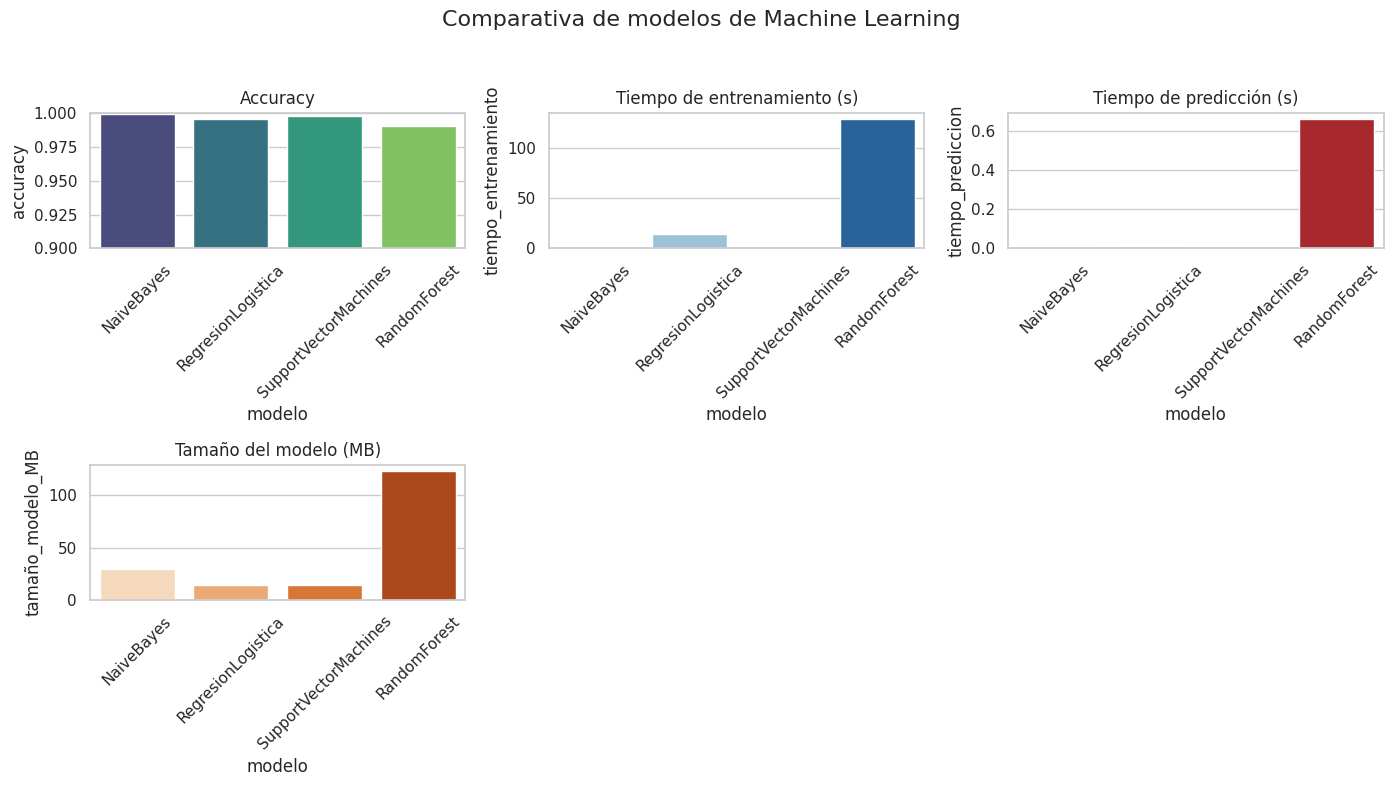

In [23]:
clasificadores = [
    ("NaiveBayes", MultinomialNB()),
    ("RegresionLogistica", LogisticRegression(max_iter=1000)),
    ("SupportVectorMachines", LinearSVC()),
    ("RandomForest", RandomForestClassifier(n_estimators=100))
]

df_resultados = comparar_modelos_ml(clasificadores, X_train_vec, X_val_vec, y_train, y_val)

Hagamos ahora una búsqueda de hiperparámetros para el modelo Naive Bayes. Para este modelo, el único relevante es $\alpha$, que es el parámetro de suavizado de Laplace.

In [24]:
valores_alpha = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# Para almacenar resultados
resultados_nb = []

for alpha in valores_alpha:
    nombre_modelo = f"NaiveBayes_alpha={alpha}"
    clasificador = MultinomialNB(alpha=alpha)
    clf_entrenado, t_entren, t_pred, tam_modelo, acc = entrenar_clasificador(
        clasificador, X_train_vec, y_train, X_val_vec, y_val, nombre_modelo
    )
    resultados_nb.append((alpha, acc, t_entren, t_pred, tam_modelo))

# Mostrar resultados ordenados por accuracy
df_resultados_nb = pd.DataFrame(resultados_nb, columns=['alpha', 'accuracy', 'tiempo_entrenamiento', 'tiempo_prediccion', 'tamaño_modelo_MB'])
df_resultados_nb = df_resultados_nb.sort_values(by='accuracy', ascending=False)

print("\n=== Resultados de la búsqueda de hiperparámetros para Naive Bayes ===")
print(df_resultados_nb)

Entrenando NaiveBayes_alpha=0.001...
  Tiempo de entrenamiento: 0.07 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 59.54 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9978
--------------------------------------------------
Entrenando NaiveBayes_alpha=0.01...
  Tiempo de entrenamiento: 0.04 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 29.88 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9980
--------------------------------------------------
Entrenando NaiveBayes_alpha=0.1...
  Tiempo de entrenamiento: 0.04 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 14.81 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9992
--------------------------------------------------
Entrenando NaiveBayes_alpha=0.5...
  Tiempo de entrenamiento: 0.04 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entren

In [25]:
valores_alpha = [0.5,0.6,0.7,0.8,0.9,1.0]

# Para almacenar resultados
resultados_nb = []

for alpha in valores_alpha:
    nombre_modelo = f"NaiveBayes_alpha={alpha}"
    clasificador = MultinomialNB(alpha=alpha)
    clf_entrenado, t_entren, t_pred, tam_modelo, acc = entrenar_clasificador(
        clasificador, X_train_vec, y_train, X_val_vec, y_val, nombre_modelo
    )
    resultados_nb.append((alpha, acc, t_entren, t_pred, tam_modelo))

# Mostrar resultados ordenados por accuracy
df_resultados_nb = pd.DataFrame(resultados_nb, columns=['alpha', 'accuracy', 'tiempo_entrenamiento', 'tiempo_prediccion', 'tamaño_modelo_MB'])
df_resultados_nb = df_resultados_nb.sort_values(by='accuracy', ascending=False)

print("\n=== Resultados de la búsqueda de hiperparámetros para Naive Bayes ===")
print(df_resultados_nb)

Entrenando NaiveBayes_alpha=0.5...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9992
--------------------------------------------------
Entrenando NaiveBayes_alpha=0.6...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9992
--------------------------------------------------
Entrenando NaiveBayes_alpha=0.7...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9992
--------------------------------------------------
Entrenando NaiveBayes_alpha=0.8...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamient

Luego el modelo Naive Bayes con $\alpha = 0.5$ obtiene en el conjunto de validación un accuracy de 0.999184. Este es un resultado realmente satisfactorio, además teniendo en cuenta que el modelo que ha dado mejores resultados es uno tan sencillo como Naive Bayes.

Naive Bayes es especialmente eficaz para detectar idiomas porque se basa en frecuencias de palabras o caracteres, y cada idioma tiene patrones léxicos muy distintivos. Aunque el modelo asume independencia entre características, este supuesto no afecta negativamente en esta tarea, ya que no se necesita comprender el significado del texto, solo identificar qué palabras o letras aparecen con más frecuencia.

Veamos ahora la matriz de confusión y anañicemos los casos en los que el modelo no ha sido capaz de dar una predicción correcta.

In [26]:
def evaluar_modelo(modelo, X, y, etiquetas, conjunto='Validación', df=None):
    """
    Evalúa el modelo en un conjunto de datos.

    Args:
        modelo: Modelo entrenado
        X: Datos de entrada
        y: Etiquetas reales
        etiquetas: Nombres de las clases
        conjunto: Nombre del conjunto (para mostrar)
        df: DataFrame con textos para análisis (opcional)

    Returns:
        Métricas de evaluación
    """
    # Convertimos a array si es necesario
    if not isinstance(X, np.ndarray):
        X_array = X.toarray()
    else:
        X_array = X

    # Predicciones
    y_pred = modelo.predict(X_array)
    y_pred_prob = modelo.predict_proba(X_array) if hasattr(modelo, "predict_proba") else None

    # Métricas
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, target_names=etiquetas, output_dict=True)

    # Visualizamos matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title(f'Matriz de Confusión - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Mostramos métricas
    print(f"Resultados en conjunto de {conjunto}:")
    print(f"Precisión global: {accuracy:.4f}\n")
    print("Métricas por clase:")

    # Creamos DataFrame para mejor visualización
    metrics_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in etiquetas],
        'Recall': [report[label]['recall'] for label in etiquetas],
        'F1-Score': [report[label]['f1-score'] for label in etiquetas],
        'Support': [report[label]['support'] for label in etiquetas]
    }, index=etiquetas)

    display(metrics_df)

    # Visualizamos métricas principales
    plt.figure(figsize=(12, 5))
    metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 5))
    plt.title(f'Métricas por Clase - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Idioma', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.9, 1.05)
    plt.legend(title='Métrica')
    plt.tight_layout()
    plt.show()

    # Análisis de ejemplos incorrectos
    incorrect_indices = np.where(y != y_pred)[0]
    if len(incorrect_indices) > 0 and df is not None:
        print(f"\nEjemplos incorrectamente clasificados ({len(incorrect_indices)}):")

        # Mostramos algunos ejemplos representativos
        # Elegimos hasta 5 ejemplos, priorizando diversidad de clases
        selected_indices = []
        seen_pairs = set()

        for idx in incorrect_indices:
            true_label = y[idx]
            pred_label = y_pred[idx]
            pair = (true_label, pred_label)

            if pair not in seen_pairs and len(selected_indices) < 5:
                seen_pairs.add(pair)
                selected_indices.append(idx)

        # Si no tenemos 5 ejemplos todavía, añadimos más
        remaining = 5 - len(selected_indices)
        if remaining > 0 and len(incorrect_indices) > len(selected_indices):
            additional_indices = [idx for idx in incorrect_indices if idx not in selected_indices]
            selected_indices.extend(additional_indices[:remaining])

        # Mostramos los ejemplos seleccionados
        for idx in selected_indices:
            texto = df.iloc[idx]['texto']
            intent_real = etiquetas[y[idx]]
            intent_pred = etiquetas[y_pred[idx]]
            prob = y_pred_prob[idx][y_pred[idx]]

            print(f"\nTexto: '{texto}'")
            print(f"  - Idioma correcto: {intent_real}")
            print(f"  - Idioma predicho: {intent_pred}")
            print(f"  - Confianza: {prob:.4f}")

            # Mostramos top 3 predicciones
            top3_idx = np.argsort(y_pred_prob[idx])[::-1][:3]
            print("  - Top 3 predicciones:")
            for i, pred_idx in enumerate(top3_idx, 1):
                print(f"    {i}. {etiquetas[pred_idx]}: {y_pred_prob[idx][pred_idx]:.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }


Entrenando NaiveBayes_alpha=0.5...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 29.84 MB
  Accuracy inicial: 0.9992
--------------------------------------------------


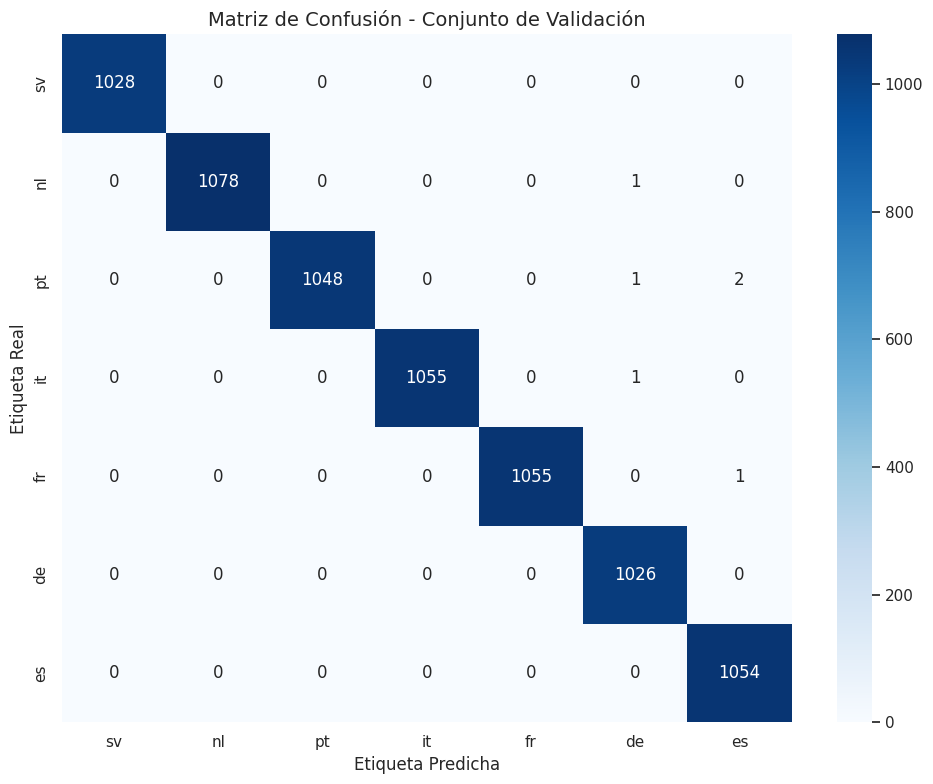

Resultados en conjunto de Validación:
Precisión global: 0.9992

Métricas por clase:


Precision    Recall  F1-Score  Support
sv   1.000000  1.000000  1.000000   1028.0
nl   1.000000  0.999073  0.999536   1079.0
pt   1.000000  0.997146  0.998571   1051.0
it   1.000000  0.999053  0.999526   1056.0
fr   1.000000  0.999053  0.999526   1056.0
de   0.997085  1.000000  0.998540   1026.0
es   0.997162  1.000000  0.998579   1054.0

<Figure size 1200x500 with 0 Axes>

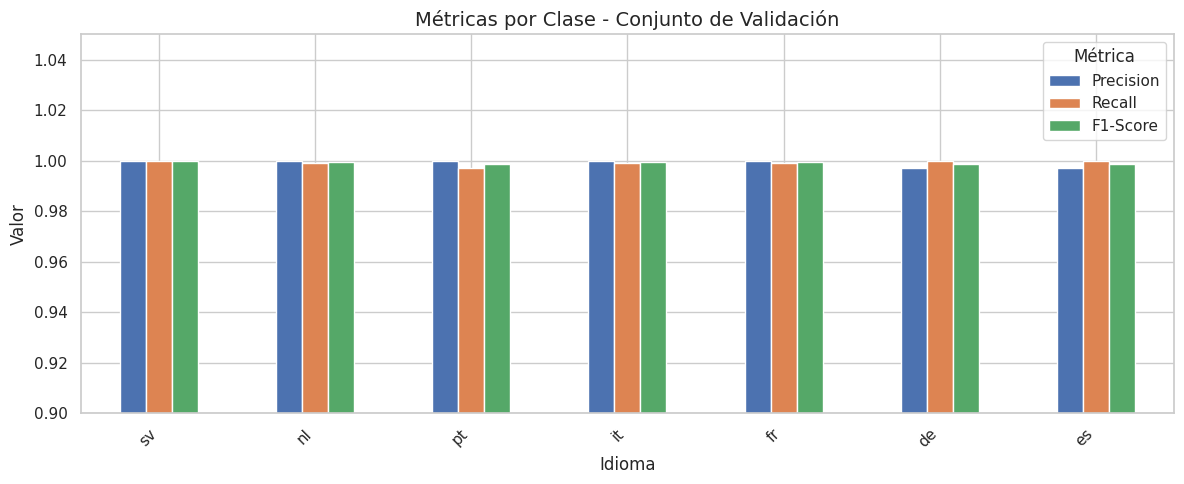


Ejemplos incorrectamente clasificados (6):

Texto: 'Relazione Graefe zu Baringdorf (A5-0015/2000)'
  - Idioma correcto: it
  - Idioma predicho: de
  - Confianza: 0.3667
  - Top 3 predicciones:
    1. de: 0.3667
    2. sv: 0.2410
    3. it: 0.1274

Texto: '­ Relatório Graefe zu Baringdorf (A5­0015/2000)'
  - Idioma correcto: pt
  - Idioma predicho: de
  - Confianza: 0.3367
  - Top 3 predicciones:
    1. de: 0.3367
    2. pt: 0.2303
    3. sv: 0.2213

Texto: 'Verslag-Graefe zu Baringdorf (A5-0015/2000)'
  - Idioma correcto: nl
  - Idioma predicho: de
  - Confianza: 0.3687
  - Top 3 predicciones:
    1. de: 0.3687
    2. sv: 0.2426
    3. es: 0.1215

Texto: 'É o que falta.'
  - Idioma correcto: pt
  - Idioma predicho: es
  - Confianza: 0.5151
  - Top 3 predicciones:
    1. es: 0.5151
    2. pt: 0.2937
    3. fr: 0.0825

Texto: '(Fin de la fiction).'
  - Idioma correcto: fr
  - Idioma predicho: es
  - Confianza: 0.6003
  - Top 3 predicciones:
    1. es: 0.6003
    2. fr: 0.3831
    3. it:

In [27]:
resultados = evaluar_modelo(entrenar_clasificador(MultinomialNB(alpha=0.5), X_train_vec, y_train, X_val_vec, y_val, "NaiveBayes_alpha=0.5")[0],
              X_val_vec, y_val, df_train_processed['idioma'].unique(),
               'Validación', df_val_processed)

Vamos a evaluar el modelo final en el conjunto test y guardamos el modelo.

Entrenando NaiveBayes_alpha=0.5...
  Tiempo de entrenamiento: 0.04 segundos
  Tiempo de predicción: 0.01 segundos
  Memoria utilizada durante entrenamiento: 0.00 MB
  Tamaño del modelo guardado: 34.49 MB
  Accuracy inicial: 0.9992
--------------------------------------------------


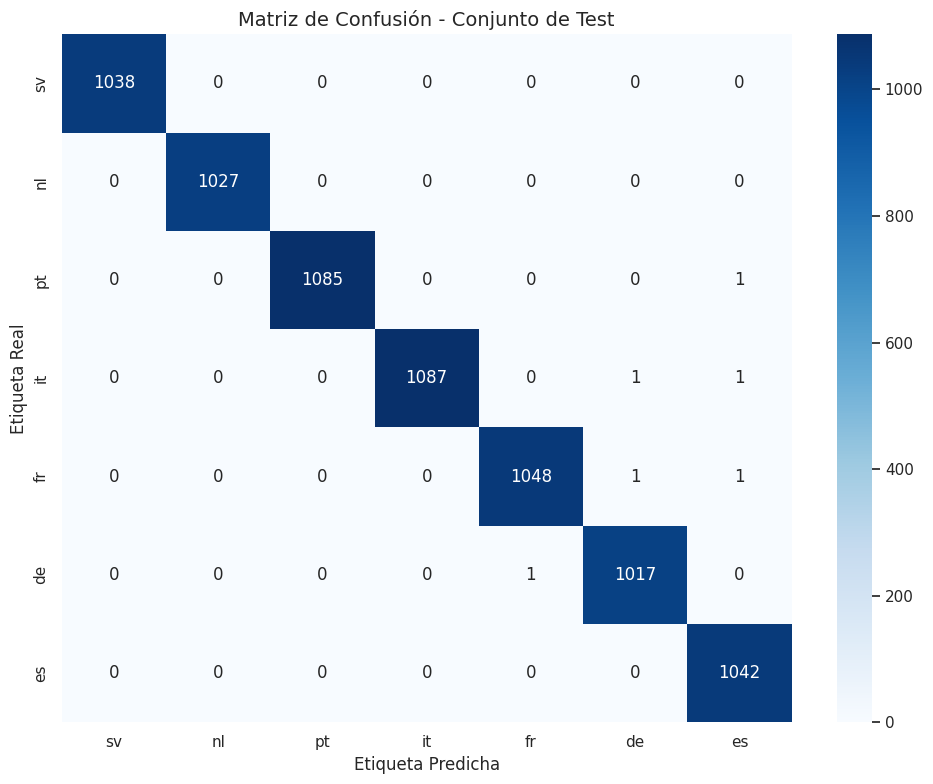

Resultados en conjunto de Test:
Precisión global: 0.9992

Métricas por clase:


Precision    Recall  F1-Score  Support
sv   1.000000  1.000000  1.000000   1038.0
nl   1.000000  1.000000  1.000000   1027.0
pt   1.000000  0.999079  0.999539   1086.0
it   1.000000  0.998163  0.999081   1089.0
fr   0.999047  0.998095  0.998571   1050.0
de   0.998037  0.999018  0.998527   1018.0
es   0.997129  1.000000  0.998563   1042.0

<Figure size 1200x500 with 0 Axes>

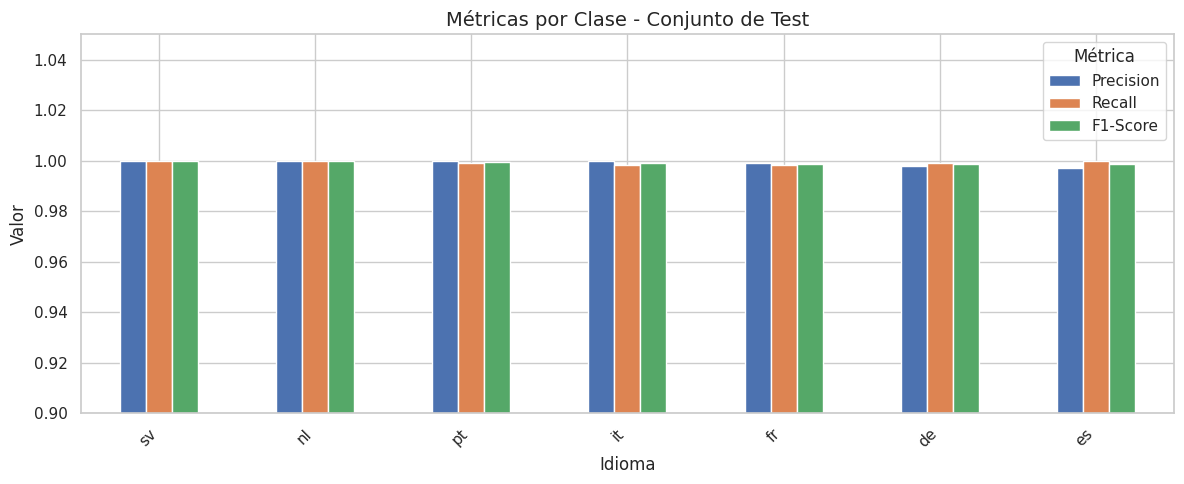


Ejemplos incorrectamente clasificados (6):

Texto: 'Monsieur Bolkestein, je veux vous dire quelque chose!'
  - Idioma correcto: de
  - Idioma predicho: fr
  - Confianza: 0.9847
  - Top 3 predicciones:
    1. fr: 0.9847
    2. it: 0.0056
    3. pt: 0.0035

Texto: 'Estamos profundamente desapontados.'
  - Idioma correcto: pt
  - Idioma predicho: es
  - Confianza: 0.4795
  - Top 3 predicciones:
    1. es: 0.4795
    2. pt: 0.4438
    3. sv: 0.0154

Texto: 'Where is the beef?'
  - Idioma correcto: it
  - Idioma predicho: de
  - Confianza: 0.2496
  - Top 3 predicciones:
    1. de: 0.2496
    2. pt: 0.2403
    3. fr: 0.1897

Texto: 'Joyeuse Saint-Valentin !'
  - Idioma correcto: fr
  - Idioma predicho: es
  - Confianza: 0.1843
  - Top 3 predicciones:
    1. es: 0.1843
    2. it: 0.1787
    3. sv: 0.1276

Texto: 'Rapport Graefe zu Baringdorf (A5-0015/2000)'
  - Idioma correcto: fr
  - Idioma predicho: de
  - Confianza: 0.2444
  - Top 3 predicciones:
    1. de: 0.2444
    2. sv: 0.2292
    3.

In [28]:
MODELS_DIR = "/content/drive/MyDrive/Colab_Notebooks/PLNCD/LanguageDetection/modelos"
X_train_val = pd.concat([df_train_processed['texto_procesado'], df_val_processed['texto_procesado']])
y_train_val = pd.concat([df_train_processed['idioma_idx'], df_val_processed['idioma_idx']])
X_test =  df_test_processed['texto_procesado']
y_test = df_test_processed['idioma_idx']

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
X_train_val_vec = vectorizer.fit_transform(X_train_val)
X_test_vec = vectorizer.transform(X_test)

finalNB_clf = entrenar_clasificador(MultinomialNB(alpha = 0.5), X_train_val_vec, y_train_val, X_test_vec, y_test, "NaiveBayes_alpha=0.5")[0]
evaluar_modelo(finalNB_clf, X_test_vec, y_test, df_train_processed['idioma'].unique(), 'Test', df_test_processed)
os.makedirs(MODELS_DIR, exist_ok=True)  # Crea el directorio si no existe

# Nombre del archivo del modelo
ruta_modelo = os.path.join(MODELS_DIR, "naive_bayes_alpha_0.5.joblib")

# Guardar el modelo
joblib.dump(finalNB_clf, ruta_modelo)

print(f"Modelo guardado en: {ruta_modelo}")

Como vemos, el modelo comete algunos errores con idiomas que tienen alta similaridad.

#### Apartado 5.2. Modelos de Deep Learning

Pasemos ahora a entrenar modelos RNN (Recurrent Neural Networks), en concreto LSTM unidireccional y bidireccional, pues evitan el problema del desvanecimiento del gradiente. Estos modelos requieren un preprocesamiento diferente basado en secuencias de tokens.

Damos ahora una serie de funciones que nos permiten crear modelos LSTM.

In [29]:
# Función para realizar tokenización y padding
def preprocesar_secuencias(textos_train, textos_val, textos_test, max_palabras=10000, max_longitud=None):
    """
    Preprocesa textos para modelos recurrentes mediante tokenización y padding.

    Args:
        textos_train: Lista de textos de entrenamiento
        textos_val: Lista de textos de validación
        textos_test: Lista de textos de prueba
        max_palabras: Tamaño máximo del vocabulario
        max_longitud: Longitud máxima de las secuencias (si es None, se calcula automáticamente)

    Returns:
        Datos preprocesados y tokenizador
    """
    # Inicializamos el tokenizador
    tokenizer = Tokenizer(num_words=max_palabras, oov_token="<OOV>")

    # Ajustamos el tokenizador en los datos de entrenamiento
    tokenizer.fit_on_texts(textos_train)

    # Convertimos textos a secuencias
    secuencias_train = tokenizer.texts_to_sequences(textos_train)
    secuencias_val = tokenizer.texts_to_sequences(textos_val)
    secuencias_test = tokenizer.texts_to_sequences(textos_test)

    # Determinamos longitud máxima si no se especifica
    if max_longitud is None:
        longitudes = [len(seq) for seq in secuencias_train]
        max_longitud = int(np.percentile(longitudes, 95))  # Usamos el percentil 95 para evitar outliers

    # Realizamos padding
    X_train = pad_sequences(secuencias_train, maxlen=max_longitud, padding='post')
    X_val = pad_sequences(secuencias_val, maxlen=max_longitud, padding='post')
    X_test = pad_sequences(secuencias_test, maxlen=max_longitud, padding='post')

    # Información sobre el vocabulario
    vocab_size = min(max_palabras, len(tokenizer.word_index) + 1)
    palabra_a_indice = tokenizer.word_index
    indice_a_palabra = {v: k for k, v in palabra_a_indice.items()}

    print(f"Preprocesamiento completado:")
    print(f"- Tamaño del vocabulario: {vocab_size} palabras")
    print(f"- Longitud máxima de secuencia: {max_longitud} tokens")
    print(f"- Ejemplos de tokenización:")

    # Mostramos ejemplos
    for i in range(min(3, len(textos_train))):
        texto = textos_train[i]
        secuencia = secuencias_train[i]
        tokens = [indice_a_palabra.get(idx, "<PAD>") if idx != 0 else "<PAD>" for idx in X_train[i]]

        print(f"  Texto: '{texto}'")
        print(f"  Secuencia: {secuencia}")
        print(f"  Con padding: {X_train[i]}")
        print(f"  Tokens: {tokens}\n")

    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'tokenizer': tokenizer,
        'vocab_size': vocab_size,
        'max_length': max_longitud,
        'word_index': palabra_a_indice,
        'index_word': indice_a_palabra
    }


# Preparamos los datos para entrenar modelos recurrentes
def preparar_datos_recurrentes():
    """
    Prepara los datos para el entrenamiento de modelos recurrentes.

    Returns:
        Diccionario con datos y configuración
    """
    # Obtenemos secuencias (X) y etiquetas (y)
    X_train = secuencias_data['X_train']
    X_val = secuencias_data['X_val']
    X_test = secuencias_data['X_test']

    # Obtenemos etiquetas
    y_train = df_train_processed['idioma_idx'].values
    y_val = df_val_processed['idioma_idx'].values
    y_test = df_test_processed['idioma_idx'].values

    # Parámetros para la arquitectura
    vocab_size = secuencias_data['vocab_size']
    max_length = secuencias_data['max_length']
    embedding_dim = 100  # Dimensión de los embeddings

    # Obtenemos los nombres de las idiomas
    idiomas = df_train['idioma'].unique()

    print(f"Datos recurrentes preparados:")
    print(f"- X_train: {X_train.shape}")
    print(f"- X_val: {X_val.shape}")
    print(f"- X_test: {X_test.shape}")
    print(f"- Vocabulario: {vocab_size} palabras")
    print(f"- Longitud máxima de secuencia: {max_length}")
    print(f"- Dimensión de embeddings: {embedding_dim}")
    print(f"- Número de clases (idiomas): {len(idiomas)}")

    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'vocab_size': vocab_size,
        'max_length': max_length,
        'embedding_dim': embedding_dim,
        'num_classes': len(idiomas),
        'idiomas': idiomas,
        'tokenizer': secuencias_data['tokenizer']
    }

# Función para crear modelo LSTM
def crear_modelo_lstm(vocab_size, embedding_dim, max_length, num_classes, dropout_rate=0.3):
    """
    Crea un modelo LSTM para detección de idiomas.

    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión de los embeddings
        max_length: Longitud máxima de las secuencias
        num_classes: Número de clases (idiomas)
        dropout_rate: Tasa de dropout para regularización

    Returns:
        Modelo compilado
    """
    model = Sequential()

    # Capa de embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ))

    # Capa LSTM
    model.add(LSTM(
        units=64,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate/2,  # Menor dropout recurrente para estabilidad
        return_sequences=False  # No devolvemos secuencias, solo el estado final
    ))

    # Capa de regularización
    model.add(Dropout(dropout_rate))

    # Capa densa de salida
    model.add(Dense(num_classes, activation='softmax'))

    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Mostramos el resumen
    model.summary()

    return model

  # Función para crear modelo LSTM bidireccional
def crear_modelo_lstm_bidireccional(vocab_size, embedding_dim, max_length, num_classes, dropout_rate=0.3):
    """
    Crea un modelo LSTM bidireccional para detección de idiomas.

    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión de los embeddings
        max_length: Longitud máxima de las secuencias
        num_classes: Número de clases (idiomas)
        dropout_rate: Tasa de dropout para regularización

    Returns:
        Modelo compilado
    """
    model = Sequential()

    # Capa de embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ))

    # Capa LSTM bidireccional
    model.add(Bidirectional(LSTM(
        units=32,  # Reducimos unidades porque al ser bidireccional se duplican
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate/2
    )))

    # Capa de regularización
    model.add(Dropout(dropout_rate))

    # Capa densa intermedia
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate/2))

    # Capa densa de salida
    model.add(Dense(num_classes, activation='softmax'))

    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Mostramos el resumen
    model.summary()

    return model

# Función para entrenar modelo
def entrenar_modelo_recurrente(modelo, datos, nombre_modelo, epochs=15, batch_size=32):
    """
    Entrena un modelo recurrente con early stopping y reducción de learning rate.

    Args:
        modelo: Modelo a entrenar
        datos: Diccionario con datos de entrenamiento y validación
        nombre_modelo: Nombre para guardar el modelo
        epochs: Número máximo de épocas
        batch_size: Tamaño del batch

    Returns:
        Historia del entrenamiento
    """
    # Callbacks
    callbacks = [
        # Early stopping para detener cuando no hay mejora
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),

        # Reducción de learning rate cuando se estanca
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=0.00001
        ),

        # Guardado del mejor modelo
        ModelCheckpoint(
            os.path.join(MODELS_DIR, f"{nombre_modelo}.keras"),
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        )
    ]

    # Entrenamos el modelo
    history = modelo.fit(
        datos['X_train'], datos['y_train'],
        validation_data=(datos['X_val'], datos['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Función para visualizar el entrenamiento
def visualizar_entrenamiento_recurrente(history, title="Entrenamiento del Modelo"):
    """
    Visualiza la evolución del entrenamiento del modelo.

    Args:
        history: Historial del entrenamiento
        title: Título del gráfico
    """
    # Extraemos métricas
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Configuramos la figura
    plt.figure(figsize=(14, 5))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Precisión entrenamiento')
    plt.plot(epochs_range, val_acc, 'ro-', label='Precisión validación')
    plt.title('Precisión de Entrenamiento y Validación', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Precisión', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Pérdida entrenamiento')
    plt.plot(epochs_range, val_loss, 'ro-', label='Pérdida validación')
    plt.title('Pérdida de Entrenamiento y Validación', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Pérdida', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # Métricas finales
    final_epoch = len(acc)
    print(f"Métricas finales ({final_epoch} épocas):")
    print(f"  Precisión entrenamiento: {acc[-1]:.4f}")
    print(f"  Precisión validación: {val_acc[-1]:.4f}")
    print(f"  Pérdida entrenamiento: {loss[-1]:.4f}")
    print(f"  Pérdida validación: {val_loss[-1]:.4f}")

    # Mejor época
    best_epoch = np.argmax(val_acc) + 1
    print(f"\nMejor rendimiento (época {best_epoch}):")
    print(f"  Precisión validación: {max(val_acc):.4f}")
    print(f"  Pérdida validación: {val_loss[best_epoch-1]:.4f}")

    # Análisis de sobreajuste
    overfit_gap = acc[-1] - val_acc[-1]
    print(f"\nBrecha de entrenamiento-validación: {overfit_gap:.4f}")
    if overfit_gap > 0.1:
        print("⚠ Posible sobreajuste detectado. Considerar mayor regularización.")
    else:
        print("✓ No hay señales significativas de sobreajuste.")

# Función para evaluar modelos recurrentes
def evaluar_modelo_recurrente(modelo, datos, conjunto='Validación'):
    """
    Evalúa un modelo recurrente en un conjunto de datos.

    Args:
        modelo: Modelo entrenado
        datos: Diccionario con datos
        conjunto: 'Validación' o 'Prueba'

    Returns:
        Diccionario con métricas de evaluación
    """
    # Seleccionamos datos según el conjunto
    if conjunto.lower() == 'validación' or conjunto.lower() == 'validacion':
        X = datos['X_val']
        y = datos['y_val']
        df = df_val
    else:  # Prueba por defecto
        X = datos['X_test']
        y = datos['y_test']
        df = df_test

    # Realizamos predicciones
    y_pred_prob = modelo.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculamos métricas
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, target_names=datos['idiomas'], output_dict=True)

    # Visualizamos matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=datos['idiomas'], yticklabels=datos['idiomas'])
    plt.title(f'Matriz de Confusión - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Mostramos métricas
    print(f"Resultados en conjunto de {conjunto}:")
    print(f"Precisión global: {accuracy:.4f}\n")
    print("Métricas por clase:")

    # Creamos DataFrame para mejor visualización
    metrics_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in datos['idiomas']],
        'Recall': [report[label]['recall'] for label in datos['idiomas']],
        'F1-Score': [report[label]['f1-score'] for label in datos['idiomas']],
        'Support': [report[label]['support'] for label in datos['idiomas']]
    }, index=datos['idiomas'])

    display(metrics_df)

    # Visualizamos métricas principales
    plt.figure(figsize=(12, 5))

    # Precision, Recall, F1 por clase
    metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 5))
    plt.title(f'Métricas por Clase - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Idioma', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Métrica')
    plt.tight_layout()
    plt.show()

    # Analizamos ejemplos incorrectos
    incorrect_indices = np.where(y != y_pred)[0]
    if len(incorrect_indices) > 0:
        print(f"\nEjemplos incorrectamente clasificados ({len(incorrect_indices)}):")

        # Mostramos algunos ejemplos representativos
        selected_indices = incorrect_indices[:min(5, len(incorrect_indices))]

        for idx in selected_indices:
            # Obtenemos el texto original
            texto_original = df.iloc[idx]['texto']

            # Convertimos secuencia a tokens
            tokens = []
            for token_id in X[idx]:
                if token_id > 0:  # Ignoramos padding (0)
                    word = datos['tokenizer'].index_word.get(token_id, "<OOV>")
                    tokens.append(word)

            texto_tokens = " ".join(tokens)

            # Obtenemos idiomas y confianzas
            intent_real = datos['idiomas'][y[idx]]
            intent_pred = datos['idiomas'][y_pred[idx]]
            conf_pred = y_pred_prob[idx][y_pred[idx]]
            conf_real = y_pred_prob[idx][y[idx]]

            print(f"\nTexto original: '{texto_original}'")
            print(f"Tokens: '{texto_tokens}'")
            print(f"  - Idioma real: {intent_real}")
            print(f"  - Idioma predicho: {intent_pred}")
            print(f"  - Confianza en predicción: {conf_pred:.4f}")
            print(f"  - Confianza en idioma real: {conf_real:.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

In [30]:

# Realizamos el preprocesamiento de secuencias
print("Preprocesando datos para redes recurrentes...")
secuencias_data = preprocesar_secuencias(
    df_train_processed['texto_procesado'],
    df_val_processed['texto_procesado'].values,
    df_test_processed['texto_procesado'].values,
    max_palabras=100
)
datos_recurrentes = preparar_datos_recurrentes()

Preprocesando datos para redes recurrentes...
Preprocesamiento completado:
- Tamaño del vocabulario: 100 palabras
- Longitud máxima de secuencia: 20 tokens
- Ejemplos de tokenización:
  Texto: 'jag tror att hon efter sitt tal kommer att få ta emot en störtflod av brev från de kinesiska myndigheterna.'
  Secuencia: [46, 1, 14, 1, 1, 1, 1, 1, 14, 1, 1, 1, 6, 1, 56, 1, 1, 2, 1, 1]
  Con padding: [46  1 14  1  1  1  1  1 14  1  1  1  6  1 56  1  1  2  1  1]
  Tokens: ['jag', '<OOV>', 'att', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', 'att', '<OOV>', '<OOV>', '<OOV>', 'en', '<OOV>', 'av', '<OOV>', '<OOV>', 'de', '<OOV>', '<OOV>']

  Texto: 'den stora frågan är snarare under vilket budgetområde denna hjälp skall finansieras.'
  Secuencia: [25, 1, 1, 26, 1, 1, 1, 1, 1, 1, 1, 1]
  Con padding: [25  1  1 26  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0]
  Tokens: ['den', '<OOV>', '<OOV>', 'är', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<PAD>', '<PAD>', '<PAD>',

Modelo LSTM unidireccional.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo LSTM:
Epoch 1/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6352 - loss: 0.9308
Epoch 1: val_loss improved from inf to 0.22054, saving model to /content/drive/MyDrive/Colab_Notebooks/PLNCD/LanguageDetection/modelos/modelo_lstm.keras
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 96s 82ms/step - accuracy: 0.6354 - loss: 0.9305 - val_accuracy: 0.9238 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 2/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9148 - loss: 0.2553
Epoch 2: val_loss improved from 0.22054 to 0.20930, saving model to /content/drive/MyDrive/Colab_Notebooks/PLNCD/LanguageDetection/modelos/modelo_lstm.keras
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 88s 82ms/step - accuracy: 0.9148 - loss: 0.2553 - val_accuracy: 0.9219 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 3/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9250 - loss: 0.2185
Epoch 3: val_loss improved from 0.20930 to 0.18723, saving model to /content/drive/MyDrive/Colab_Notebooks/P

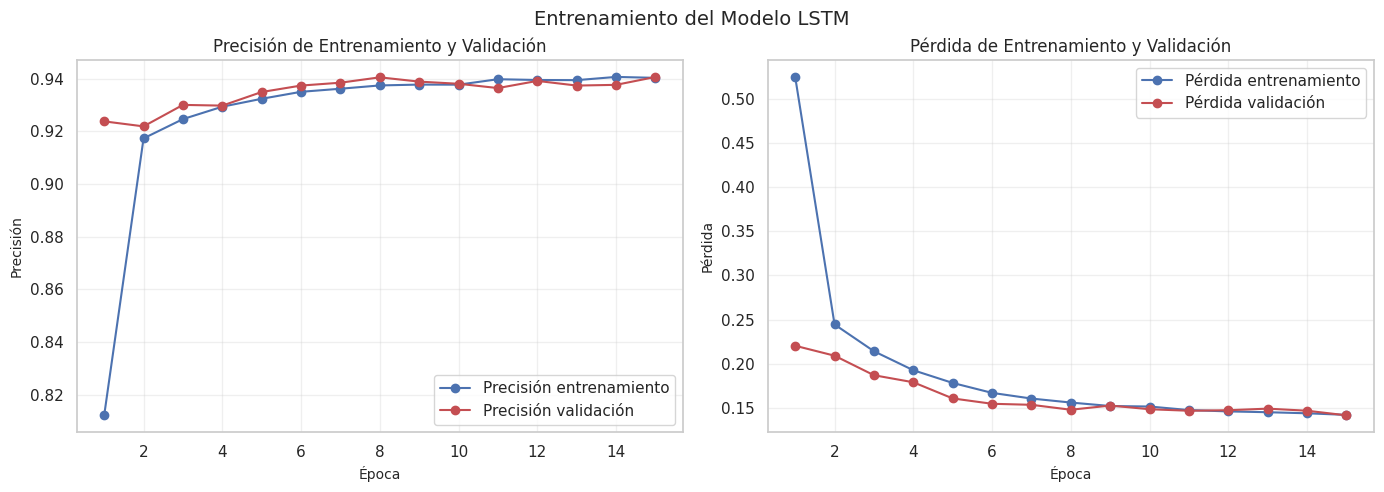

Métricas finales (15 épocas):
  Precisión entrenamiento: 0.9403
  Precisión validación: 0.9407
  Pérdida entrenamiento: 0.1424
  Pérdida validación: 0.1419

Mejor rendimiento (época 15):
  Precisión validación: 0.9407
  Pérdida validación: 0.1419

Brecha de entrenamiento-validación: -0.0003
✓ No hay señales significativas de sobreajuste.

Evaluando modelo LSTM:
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


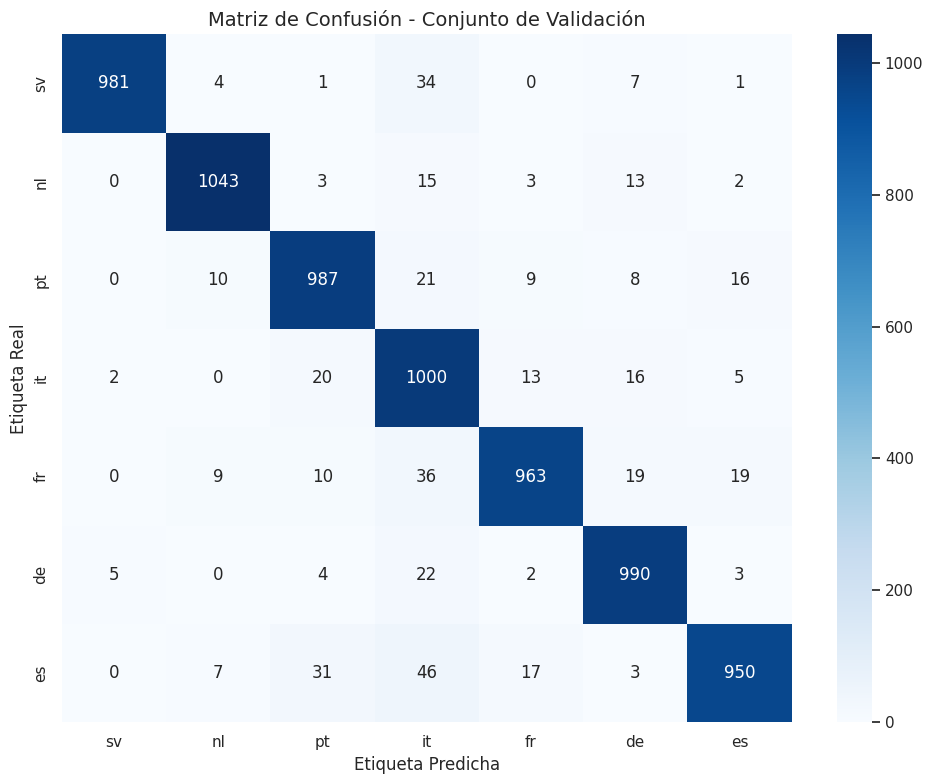

Resultados en conjunto de Validación:
Precisión global: 0.9407

Métricas por clase:


Precision    Recall  F1-Score  Support
sv   0.992915  0.954280  0.973214   1028.0
nl   0.972041  0.966636  0.969331   1079.0
pt   0.934659  0.939106  0.936877   1051.0
it   0.851789  0.946970  0.896861   1056.0
fr   0.956306  0.911932  0.933592   1056.0
de   0.937500  0.964912  0.951009   1026.0
es   0.953815  0.901328  0.926829   1054.0

<Figure size 1200x500 with 0 Axes>

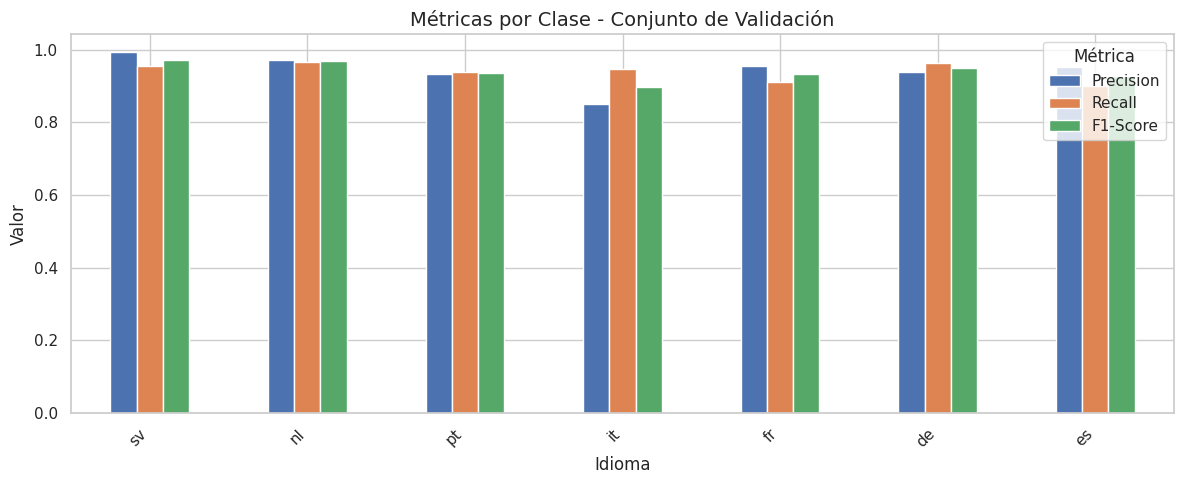


Ejemplos incorrectamente clasificados (436):

Texto original: 'Temos de mudar resolutamente de rumo.'
Tokens: '<OOV> de <OOV> <OOV> de <OOV>'
  - Idioma real: pt
  - Idioma predicho: nl
  - Confianza en predicción: 0.4747
  - Confianza en idioma real: 0.1111

Texto original: 'Estou perfeitamente de acordo.'
Tokens: '<OOV> <OOV> de <OOV>'
  - Idioma real: pt
  - Idioma predicho: fr
  - Confianza en predicción: 0.2905
  - Confianza en idioma real: 0.1690

Texto original: 'Tenslotte moet deze richtlijn zo snel mogelijk in werking treden.'
Tokens: '<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> in <OOV> <OOV>'
  - Idioma real: nl
  - Idioma predicho: de
  - Confianza en predicción: 0.4376
  - Confianza en idioma real: 0.1728

Texto original: 'Elle assume d'ailleurs ses responsabilités.'
Tokens: '<OOV> <OOV> <OOV> <OOV> <OOV>'
  - Idioma real: fr
  - Idioma predicho: it
  - Confianza en predicción: 0.1856
  - Confianza en idioma real: 0.1265

Texto original: 'Relazione Graefe zu Baringdorf (A5-

In [31]:
# Creamos el modelo LSTM
modelo_lstm = crear_modelo_lstm(
    vocab_size=datos_recurrentes['vocab_size'],
    embedding_dim=datos_recurrentes['embedding_dim'],
    max_length=datos_recurrentes['max_length'],
    num_classes=datos_recurrentes['num_classes']
)

# Entrenamos el modelo LSTM
print("\nEntrenando modelo LSTM:")
history_lstm = entrenar_modelo_recurrente(
    modelo_lstm,
    datos_recurrentes,
    "modelo_lstm",
    epochs=15
)

visualizar_entrenamiento_recurrente(
    history_lstm,
    "Entrenamiento del Modelo LSTM"
)

print("\nEvaluando modelo LSTM:")
eval_lstm = evaluar_modelo_recurrente(
    modelo_lstm,
    datos_recurrentes,
    conjunto='Validación'
)

Modelo LSTM bidireccional.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo LSTM bidireccional:
Epoch 1/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6810 - loss: 0.8436
Epoch 1: val_loss improved from inf to 0.19127, saving model to /content/drive/MyDrive/Colab_Notebooks/PLNCD/LanguageDetection/modelos/modelo_bilstm.keras
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 159s 138ms/step - accuracy: 0.6812 - loss: 0.8432 - val_accuracy: 0.9272 - val_loss: 0.1913 - learning_rate: 0.0010
Epoch 2/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9270 - loss: 0.2049
Epoch 2: val_loss improved from 0.19127 to 0.17394, saving model to /content/drive/MyDrive/Colab_Notebooks/PLNCD/LanguageDetection/modelos/modelo_bilstm.keras
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 195s 131ms/step - accuracy: 0.9270 - loss: 0.2049 - val_accuracy: 0.9306 - val_loss: 0.1739 - learning_rate: 0.0010
Epoch 3/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9315 - loss: 0.1822
Epoch 3: val_loss improved from 0.17394 to 0.16265, saving model to /content/drive/

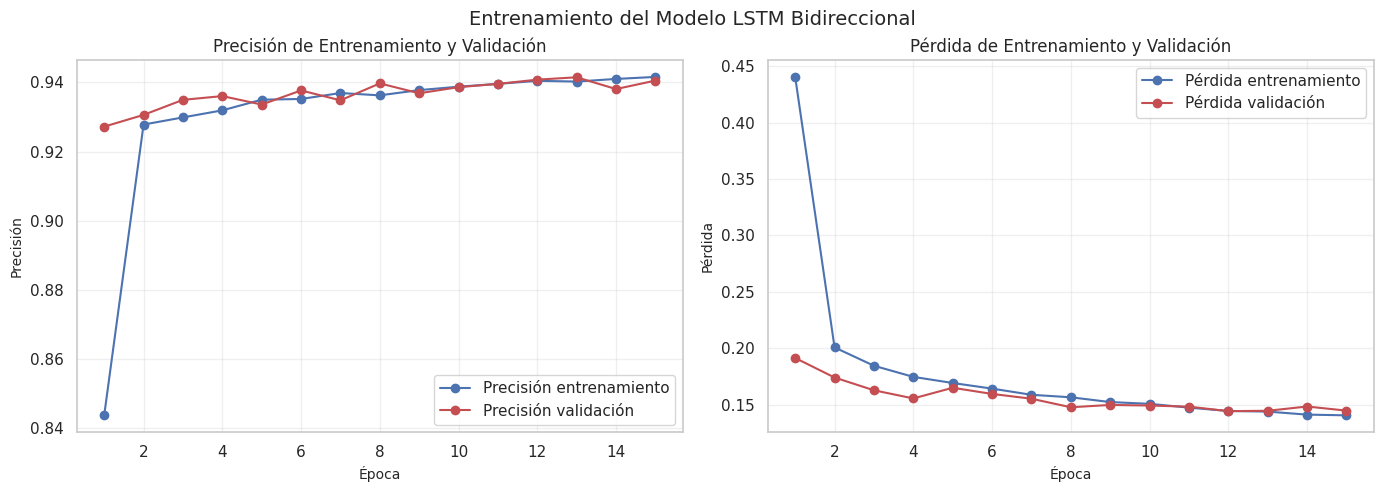

Métricas finales (15 épocas):
  Precisión entrenamiento: 0.9416
  Precisión validación: 0.9405
  Pérdida entrenamiento: 0.1404
  Pérdida validación: 0.1446

Mejor rendimiento (época 13):
  Precisión validación: 0.9415
  Pérdida validación: 0.1445

Brecha de entrenamiento-validación: 0.0011
✓ No hay señales significativas de sobreajuste.

Evaluando modelo LSTM bidireccional:
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step


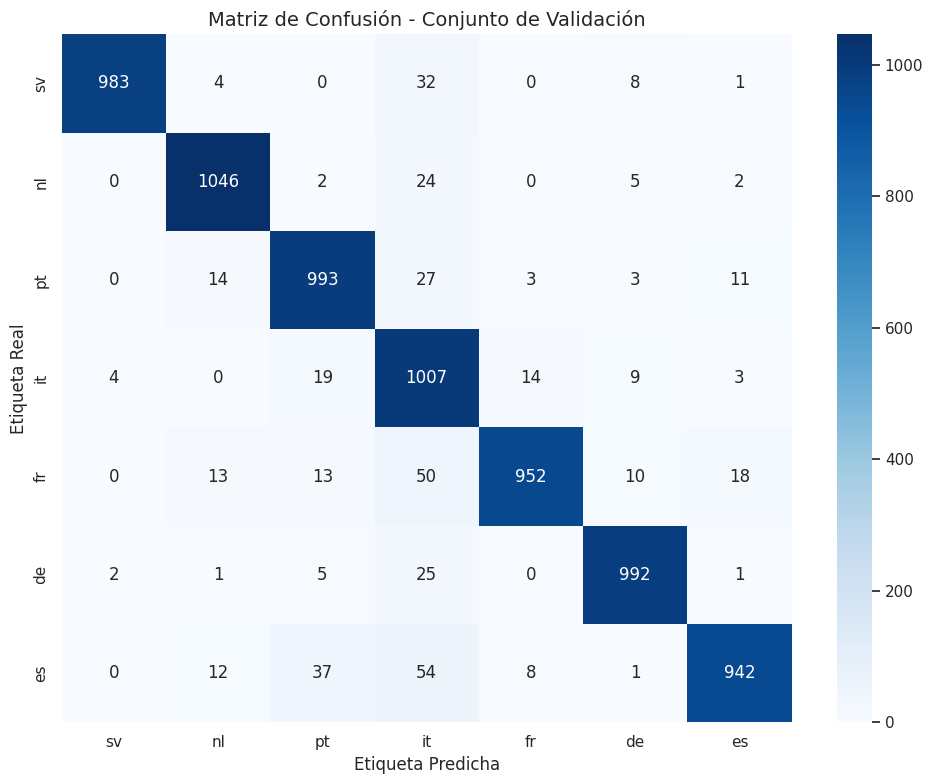

Resultados en conjunto de Validación:
Precisión global: 0.9408

Métricas por clase:


Precision    Recall  F1-Score  Support
sv   0.993933  0.956226  0.974715   1028.0
nl   0.959633  0.969416  0.964500   1079.0
pt   0.928906  0.944814  0.936792   1051.0
it   0.826087  0.953598  0.885275   1056.0
fr   0.974411  0.901515  0.936547   1056.0
de   0.964981  0.966862  0.965920   1026.0
es   0.963190  0.893738  0.927165   1054.0

<Figure size 1200x500 with 0 Axes>

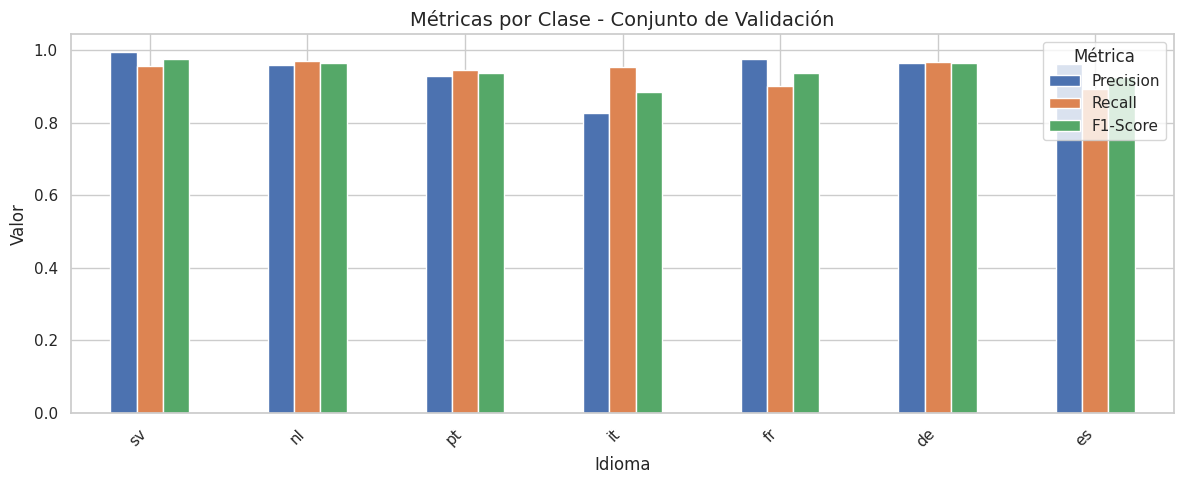


Ejemplos incorrectamente clasificados (435):

Texto original: 'Temos de mudar resolutamente de rumo.'
Tokens: '<OOV> de <OOV> <OOV> de <OOV>'
  - Idioma real: pt
  - Idioma predicho: nl
  - Confianza en predicción: 0.4531
  - Confianza en idioma real: 0.1522

Texto original: 'Auch Landwirtschaft kann nur betrieben werden, wenn sauberes Wasser in ausreichender Menge zur Verfügung steht.'
Tokens: '<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> in <OOV> <OOV> <OOV> <OOV> <OOV>'
  - Idioma real: de
  - Idioma predicho: it
  - Confianza en predicción: 0.4213
  - Confianza en idioma real: 0.4160

Texto original: 'Estou perfeitamente de acordo.'
Tokens: '<OOV> <OOV> de <OOV>'
  - Idioma real: pt
  - Idioma predicho: nl
  - Confianza en predicción: 0.3422
  - Confianza en idioma real: 0.1666

Texto original: 'Tenslotte moet deze richtlijn zo snel mogelijk in werking treden.'
Tokens: '<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> in <OOV> <OOV>'
  - Idioma real: nl
  - Idioma predicho: it
 

In [32]:
# Creamos el modelo LSTM bidireccional
modelo_bilstm = crear_modelo_lstm_bidireccional(
    vocab_size=datos_recurrentes['vocab_size'],
    embedding_dim=datos_recurrentes['embedding_dim'],
    max_length=datos_recurrentes['max_length'],
    num_classes=datos_recurrentes['num_classes']
)

# Entrenamos el modelo LSTM bidireccional
print("\nEntrenando modelo LSTM bidireccional:")
history_bilstm = entrenar_modelo_recurrente(
    modelo_bilstm,
    datos_recurrentes,
    "modelo_bilstm",
    epochs=15
)

# Visualizamos el entrenamiento
visualizar_entrenamiento_recurrente(
    history_bilstm,
    "Entrenamiento del Modelo LSTM Bidireccional"
)

# Evaluamos el modelo LSTM bidireccional
print("\nEvaluando modelo LSTM bidireccional:")
eval_bilstm = evaluar_modelo_recurrente(
    modelo_bilstm,
    datos_recurrentes,
    conjunto='Validación'
)

Comparacion de los modelos LSTM.

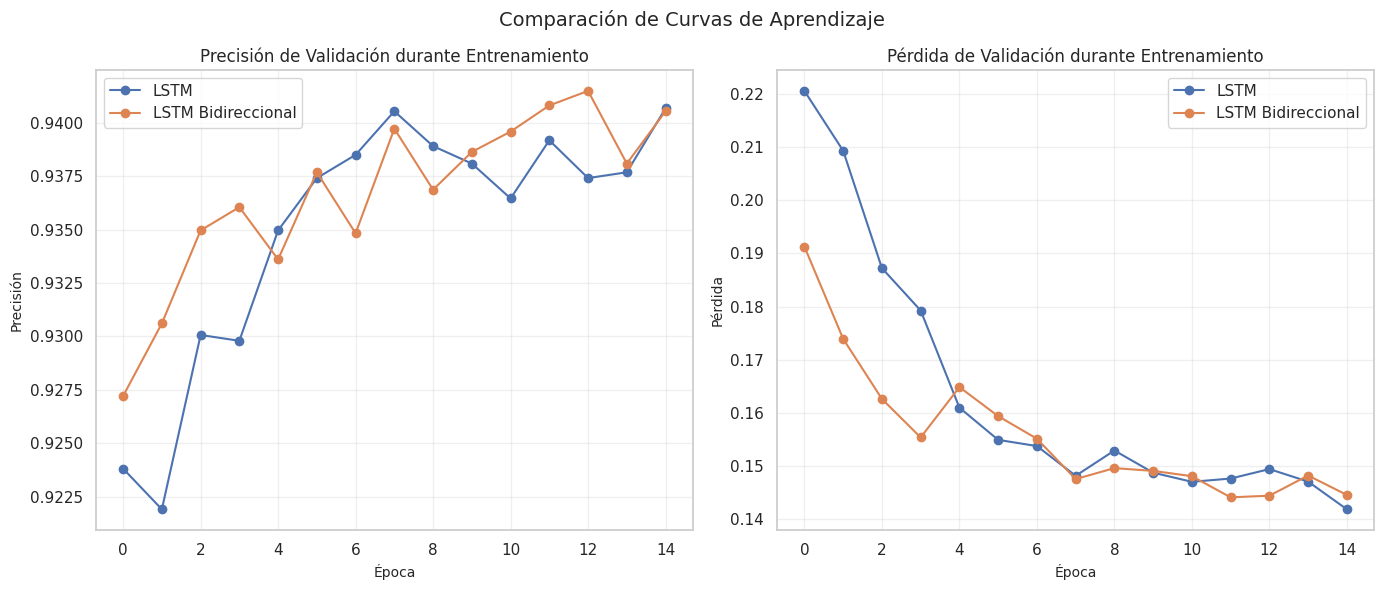


Comparación de Rendimiento:


LSTM  LSTM Bidireccional
Global           0.940680            0.940816
sv               0.973214            0.974715
nl               0.969331            0.964500
pt               0.936877            0.936792
it               0.896861            0.885275
fr               0.933592            0.936547
de               0.951009            0.965920
es               0.926829            0.927165
Macro Avg F1     0.941102            0.941559
Weighted Avg F1  0.941034            0.941412

<Figure size 1000x600 with 0 Axes>

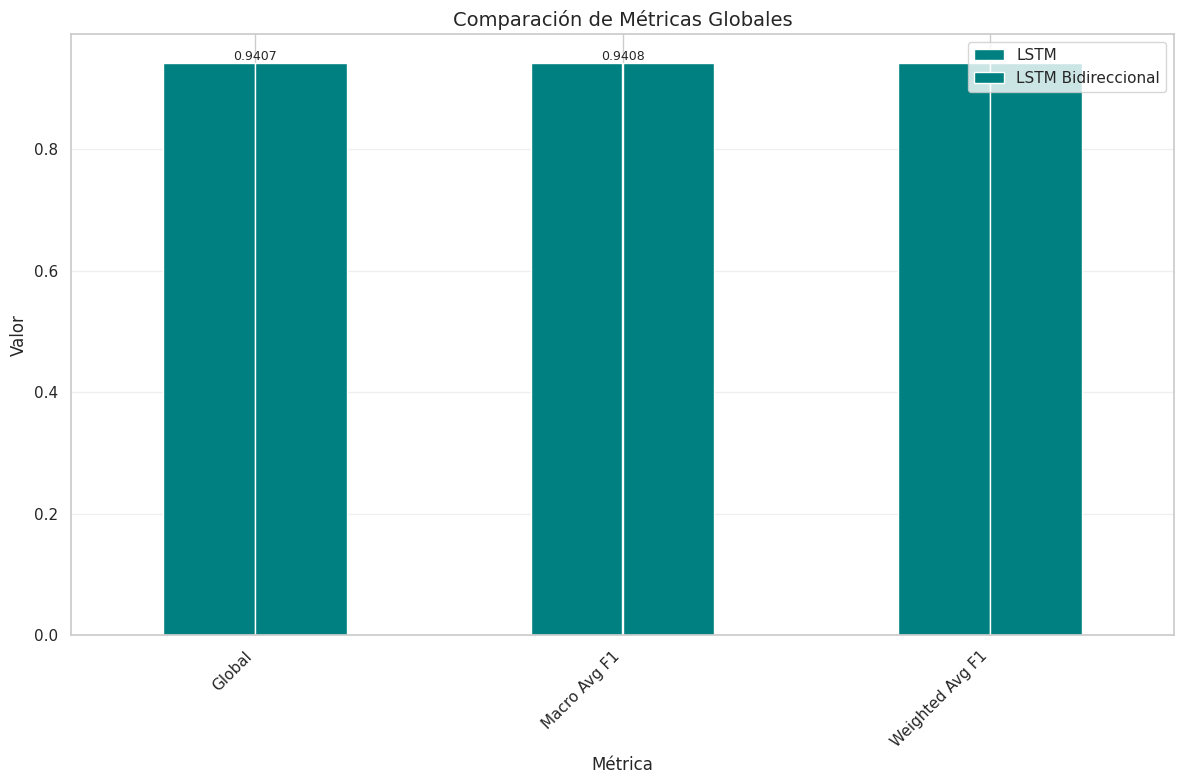

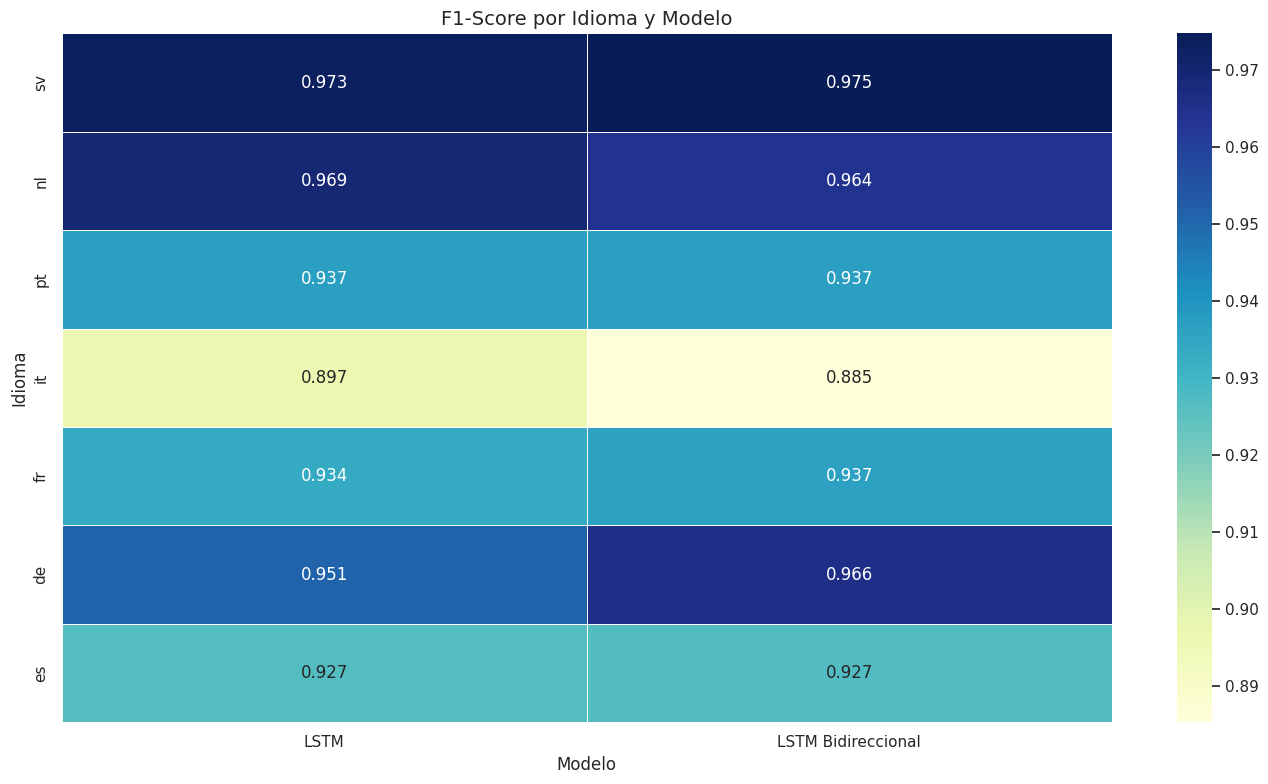


Conclusiones de la comparación:
- El mejor modelo en términos de precisión global es LSTM Bidireccional con 0.9408
- El modelo que converge más rápido es LSTM en 15 épocas
- Para el idioma 'sv', el mejor modelo es LSTM Bidireccional (F1: 0.9747)
- Para el idioma 'nl', el mejor modelo es LSTM (F1: 0.9693)
- Para el idioma 'pt', el mejor modelo es LSTM (F1: 0.9369)
- Para el idioma 'it', el mejor modelo es LSTM (F1: 0.8969)
- Para el idioma 'fr', el mejor modelo es LSTM Bidireccional (F1: 0.9365)
- Para el idioma 'de', el mejor modelo es LSTM Bidireccional (F1: 0.9659)
- Para el idioma 'es', el mejor modelo es LSTM Bidireccional (F1: 0.9272)

Ventajas y desventajas:

LSTM:
  Fortalezas: Rendimiento destacado en 'sv' (0.9732) y 'nl' (0.9693)
  Debilidades: Menor rendimiento en 'it' (0.8969) y 'es' (0.9268)

LSTM Bidireccional:
  Fortalezas: Rendimiento destacado en 'sv' (0.9747) y 'de' (0.9659)
  Debilidades: Menor rendimiento en 'it' (0.8853) y 'es' (0.9272)

El mejor modelo recurrente 

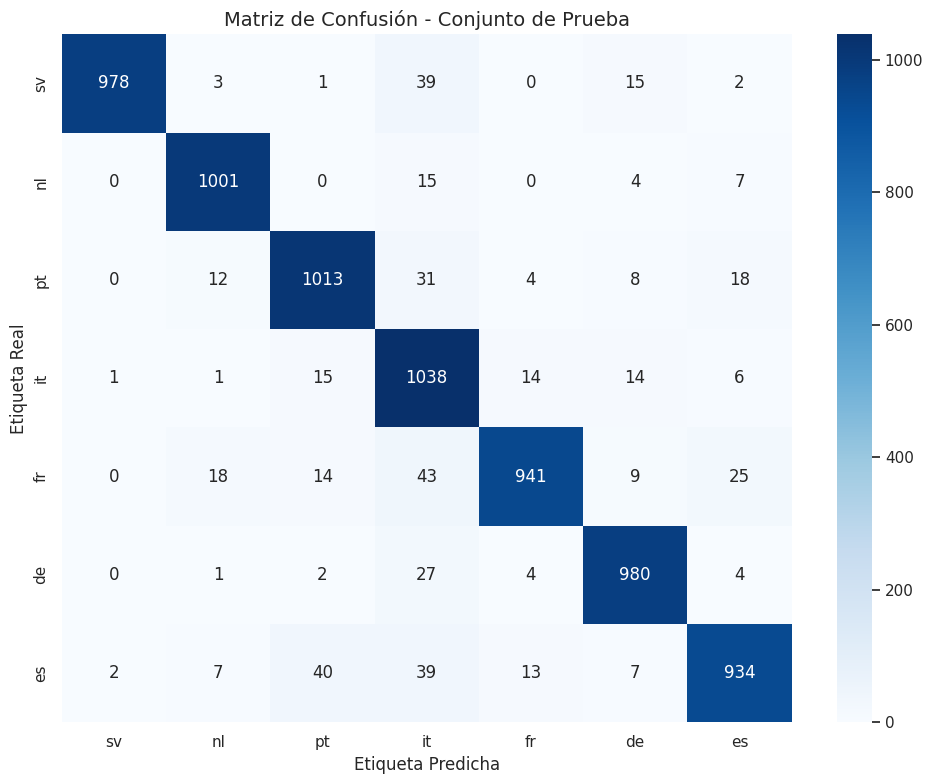

Resultados en conjunto de Prueba:
Precisión global: 0.9367

Métricas por clase:


Precision    Recall  F1-Score  Support
sv   0.996942  0.942197  0.968796   1038.0
nl   0.959732  0.974684  0.967150   1027.0
pt   0.933641  0.932781  0.933211   1086.0
it   0.842532  0.953168  0.894442   1089.0
fr   0.964139  0.896190  0.928924   1050.0
de   0.945034  0.962672  0.953771   1018.0
es   0.937751  0.896353  0.916585   1042.0

<Figure size 1200x500 with 0 Axes>

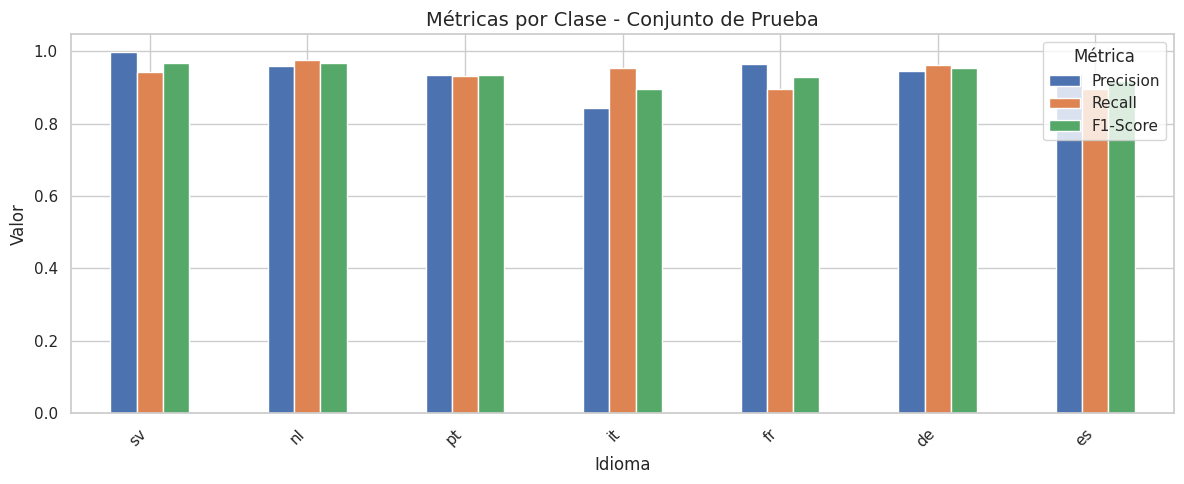


Ejemplos incorrectamente clasificados (465):

Texto original: '(EN) Gostaria de começar por felicitar o senhor deputado pela sua introdução a este debate extremamente importante.'
Tokens: 'en <OOV> de <OOV> por <OOV> o <OOV> <OOV> <OOV> <OOV> <OOV> a este <OOV> <OOV> <OOV>'
  - Idioma real: pt
  - Idioma predicho: es
  - Confianza en predicción: 0.7728
  - Confianza en idioma real: 0.2270

Texto original: 'Mi voto era "a favor" .'
Tokens: '<OOV> <OOV> <OOV> a <OOV>'
  - Idioma real: es
  - Idioma predicho: pt
  - Confianza en predicción: 0.3883
  - Confianza en idioma real: 0.2132

Texto original: 'Anfragen an Frau Wallström'
Tokens: '<OOV> <OOV> <OOV> <OOV>'
  - Idioma real: de
  - Idioma predicho: it
  - Confianza en predicción: 0.1885
  - Confianza en idioma real: 0.1479

Texto original: 'Im Rahmen des Stabilitätspakts für Südosteuropa sind weitere Maßnahmen geplant.'
Tokens: '<OOV> <OOV> des <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'
  - Idioma real: de
  - Idioma predicho: fr
  -

In [35]:
# Función para comparar los modelos recurrentes
def comparar_modelos_recurrentes(historiales, evaluaciones, nombres_modelos):
    """
    Compara diferentes modelos recurrentes.

    Args:
        historiales: Lista de historiales de entrenamiento
        evaluaciones: Lista de resultados de evaluación
        nombres_modelos: Lista de nombres de modelos
    """
    # Comparamos curvas de aprendizaje
    plt.figure(figsize=(14, 6))

    # Precisión de validación
    plt.subplot(1, 2, 1)
    for i, history in enumerate(historiales):
        plt.plot(history.history['val_accuracy'], marker='o', linestyle='-',
                label=nombres_modelos[i])

    plt.title('Precisión de Validación durante Entrenamiento', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Precisión', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Pérdida de validación
    plt.subplot(1, 2, 2)
    for i, history in enumerate(historiales):
        plt.plot(history.history['val_loss'], marker='o', linestyle='-',
                label=nombres_modelos[i])

    plt.title('Pérdida de Validación durante Entrenamiento', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Pérdida', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Comparación de Curvas de Aprendizaje', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # Comparamos métricas finales
    print("\nComparación de Rendimiento:")

    # Creamos DataFrame con métricas de precisión
    metrics_comparison = pd.DataFrame({
        nombres_modelos[i]: [eval['accuracy']] +
                        [eval['classification_report'][label]['f1-score'] for label in datos_recurrentes['idiomas']] +
                        [eval['classification_report']['macro avg']['f1-score'],
                         eval['classification_report']['weighted avg']['f1-score']]
        for i, eval in enumerate(evaluaciones)
    }, index=['Global'] + list(datos_recurrentes['idiomas']) + ['Macro Avg F1', 'Weighted Avg F1'])

    # Mostramos tabla con comparación
    display(metrics_comparison)

    # Visualizamos las métricas globales
    plt.figure(figsize=(10, 6))
    metrics_comparison.loc[['Global', 'Macro Avg F1', 'Weighted Avg F1']].plot(kind='bar', color='teal')
    plt.title('Comparación de Métricas Globales', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Métrica', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Añadimos etiquetas con valores
    for i, v in enumerate(metrics_comparison.loc['Global']):
         plt.text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)


    plt.tight_layout()
    plt.show()

    # Comparamos rendimiento por idioma
    plt.figure(figsize=(14, 8))

    # Heatmap de F1-Score por idioma y modelo
    sns.heatmap(metrics_comparison.loc[datos_recurrentes['idiomas']], annot=True,
              cmap='YlGnBu', fmt='.3f', linewidths=.5)
    plt.title('F1-Score por Idioma y Modelo', fontsize=14)
    plt.ylabel('Idioma', fontsize=12)
    plt.xlabel('Modelo', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Conclusiones
    print("\nConclusiones de la comparación:")

    # Mejor modelo global
    best_model_idx = np.argmax([eval['accuracy'] for eval in evaluaciones])
    best_model = nombres_modelos[best_model_idx]
    print(f"- El mejor modelo en términos de precisión global es {best_model} con {evaluaciones[best_model_idx]['accuracy']:.4f}")

    # Comparamos tiempo de convergencia
    epochs_to_converge = [len(history.history['val_loss']) for history in historiales]
    fastest_model_idx = np.argmin(epochs_to_converge)
    print(f"- El modelo que converge más rápido es {nombres_modelos[fastest_model_idx]} en {epochs_to_converge[fastest_model_idx]} épocas")

    # Mejor modelo por idioma
    for idioma in datos_recurrentes['idiomas']:
        scores = [eval['classification_report'][idioma]['f1-score'] for eval in evaluaciones]
        best_idx = np.argmax(scores)
        print(f"- Para el idioma '{idioma}', el mejor modelo es {nombres_modelos[best_idx]} (F1: {scores[best_idx]:.4f})")

    # Ventajas y desventajas
    print("\nVentajas y desventajas:")

    for i, model_name in enumerate(nombres_modelos):
        print(f"\n{model_name}:")

        # Fortalezas
        good_intents = metrics_comparison.loc[datos_recurrentes['idiomas']].iloc[:, i].nlargest(2).index.tolist()
        good_scores = metrics_comparison.loc[good_intents, model_name].tolist()
        print(f"  Fortalezas: Rendimiento destacado en '{good_intents[0]}' ({good_scores[0]:.4f}) y '{good_intents[1]}' ({good_scores[1]:.4f})")

        # Debilidades
        poor_intents = metrics_comparison.loc[datos_recurrentes['idiomas']].iloc[:, i].nsmallest(2).index.tolist()
        poor_scores = metrics_comparison.loc[poor_intents, model_name].tolist()
        print(f"  Debilidades: Menor rendimiento en '{poor_intents[0]}' ({poor_scores[0]:.4f}) y '{poor_intents[1]}' ({poor_scores[1]:.4f})")

# Comparamos todos los modelos recurrentes
comparar_modelos_recurrentes(
    [history_lstm, history_bilstm],
    [eval_lstm, eval_bilstm],
    ["LSTM", "LSTM Bidireccional"]
)

# Determinamos el mejor modelo recurrente
acc_recurrentes = [eval_lstm['accuracy'], eval_bilstm['accuracy']]
mejor_recurrente_idx = np.argmax(acc_recurrentes)
nombres_recurrentes = ["LSTM", "LSTM Bidireccional"]
mejor_recurrente_nombre = nombres_recurrentes[mejor_recurrente_idx]
mejor_recurrente = [modelo_lstm, modelo_bilstm][mejor_recurrente_idx]

print(f"\nEl mejor modelo recurrente es: {mejor_recurrente_nombre}")

# Evaluamos en el conjunto de prueba
print(f"\nEvaluando {mejor_recurrente_nombre} en el conjunto de prueba:")
eval_test = evaluar_modelo_recurrente(
    mejor_recurrente,
    datos_recurrentes,
    conjunto='Prueba'
)

# Guardamos el mejor modelo recurrente
modelo_path = os.path.join(MODELS_DIR, "mejor_modelo_recurrente.keras")
mejor_recurrente.save(modelo_path)

# Guardamos la configuración
config_path = os.path.join(MODELS_DIR, "mejor_modelo_recurrente_config.pkl")
with open(config_path, 'wb') as f:
    pickle.dump({
        'nombre': mejor_recurrente_nombre,
        'tokenizer': datos_recurrentes['tokenizer'],
        'max_length': datos_recurrentes['max_length'],
        'vocab_size': datos_recurrentes['vocab_size'],
        'embedding_dim': datos_recurrentes['embedding_dim'],
        'idiomas': datos_recurrentes['idiomas'],
        'accuracy_val': acc_recurrentes[mejor_recurrente_idx],
        'accuracy_test': eval_test['accuracy']
    }, f)

print(f"\nMejor modelo recurrente guardado como: {modelo_path}")
print(f"Configuración guardada como: {config_path}")

Los resultados de las redes recurrentes tipo LSTM no son tan satisfactorias como los modelos previos. La gran fortaleza de estos modelos es su capacidad para modelar dependencias a largo plazo en secuencias, pero en detección de idiomas no es necesario tener una gran información contextual del texto para realizar la tarea. Es suficiente con centrarse en detectar patrones locales sin necesidad de modelar secuencias complejas.

### Apartado 6. Conclusiones y pipeline final

En la tarea de detección de idiomas, el modelo de Naive Bayes ha demostrado un rendimiento superior frente a enfoques más complejos como LSTM unidireccional y bidireccional. Esto resalta una de las principales ventajas de Naive Bayes: su eficacia en problemas de clasificación, especialmente cuando no se requiere modelar dependencias a largo plazo entre palabras (como es el caso de esta tarea). Además, Naive Bayes es computacionalmente eficiente, fácil de interpretar y rápido de entrenar, lo que lo convierte en una opción robusta y práctica como modelo final en tareas de este tipo.

Finalizamos, dando un pipeline completo que entrena el modelo para el conjunto total de los datos, que realiza lo siguiente:
1. Realiza el proceso ETL, tomando un número $n$ de textos de las lenguas indicadas.
2. Preprocesamiento de los textos y codificación de los idiomas
3. Vectorización de los textos y entrenamiento del clasificador Naive Bayes.
4. Guarda el pipeline vectorizador + clasificador.

In [ ]:
def pipeline_completo(data_dir, langs, n_max = 7000, min_palabras=3, max_palabras=20, nombre_archivo="naive_bayes_alpha_0.5_full.joblib"):
    # Extracción de los textos
    df = extrae_textos_idiomas(data_dir, langs, n_max, min_palabras=min_palabras, max_palabras=max_palabras)

    # Preprocesamiento de los textos
    df_procesado = preprocesa_dataset(df)

    # Codificación de los idiomas
    codidioma_to_idx = {codidioma: idx for idx, codidioma in enumerate(df_procesado['idioma'].unique())}
    idx_to_codidioma = {idx: codidioma for idx, codidioma in codidioma_to_idx.items()}
    df_procesado['idioma_idx'] = df_procesado['idioma'].map(codidioma_to_idx)

    X = df_procesado['texto_procesado']
    y = df_procesado['idioma_idx']

    # Vectorización de los textos y entrenamiento del clasificador (pipeline)
    pipeline_entrenado = vectorizar_y_entrenar(X, X, y, y, 'words-tf-idf', MultinomialNB(alpha=0.5))[0]

    # Guardar el pipeline completo
    os.makedirs(MODELS_DIR, exist_ok=True)
    ruta_modelo = os.path.join(MODELS_DIR, nombre_archivo)
    joblib.dump(pipeline_entrenado, ruta_modelo)

    print(f"Modelo guardado en: {ruta_modelo}")
